# EDA - HDB Resale

### Import Environment Modules and Data

In [2]:
# Import Python Modules

# Essential Modules
import numpy as np
import pandas as pd
from scipy.stats import randint
from scipy.stats import median_abs_deviation

# Graphical Modules
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Pipeline and Train Test Split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer

## SciKit Learning Preprocessing  
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import OneHotEncoder

## SciKit Learn ML Models

# Linear Models
from sklearn.linear_model import LinearRegression, HuberRegressor, QuantileRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.compose import TransformedTargetRegressor

# Tree Based Linear Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb


# Performance Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score


## Hyper-parameter Tuning
# GridSearch CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV # type: ignore

# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingRandomSearchCV # type: ignore

# Optuna for Hyperparameter Tuning
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution


### Load Data

The following is a temporary placeholder. In a real end to end project, we need to connect to BigQuery and download the data from BigQuery using SQL extraction.

In [3]:
# Load the dataset
df = pd.read_csv('./data/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv')

In [4]:
len(df)

209579

## Problem Statement

**We work for a property consultancy company. This company want to develop an end to end machine learning pipeline that could deliver housing price prediction to customer.**

**Our task is to develop a machine learning model that could accurately predict the resale prices of HDB resale flats. This model will assist buyers or sellers in planning their budgets more effectively and set realistic expectations. This model also need to help buyers determine the type of flat they can afford and in which location. This model also should provide sellers with valuable information regarding the potential market value of their property.**

## Basic Data Exploration

In [5]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


#### Data Structure

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88688 entries, 0 to 88687
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   88688 non-null  int64  
 1   month                88688 non-null  object 
 2   flat_type            88688 non-null  object 
 3   block                88688 non-null  object 
 4   street_name          88688 non-null  object 
 5   storey_range         88688 non-null  object 
 6   floor_area_sqm       88688 non-null  float64
 7   lease_commence_date  88688 non-null  int64  
 8   remaining_lease      88688 non-null  object 
 9   resale_price         88688 non-null  float64
 10  town_id              88688 non-null  int64  
 11  flatm_id             88688 non-null  int64  
 12  town_name            87905 non-null  object 
 13  flatm_name           88174 non-null  object 
dtypes: float64(2), int64(4), object(8)
memory usage: 9.5+ MB


**Possible null values in `town_name` and `flatm_name`.**

#### Detecting Missing Values

In [6]:
df.isnull().sum()

id                       0
month                    0
flat_type                0
block                    0
street_name              0
storey_range             0
floor_area_sqm           0
lease_commence_date      0
remaining_lease          0
resale_price             0
town_id                  0
flatm_id                 0
town_name              783
flatm_name             514
dtype: int64

**Confirmed Null values in `town_name` and `flatm_name`.**

#### Descriptive Statistics

In [7]:
df.describe()

,id,floor_area_sqm,lease_commence_date,resale_price,town_id,flatm_id
count,88688.000000,88688.000000,88688.000000,8.868800e+04,88688.000000,88688.000000
mean,42233.303739,97.520444,1570.225352,4.386793e+05,14.631337,8.889185
std,24376.312037,24.197379,1226.315949,1.466703e+05,8.032285,3.906898
min,1.000000,31.000000,-2016.000000,1.600000e+05,1.000000,1.000000
25%,21136.750000,76.000000,1980.000000,3.350000e+05,8.000000,5.000000
50%,42228.500000,96.000000,1988.000000,4.080000e+05,15.000000,8.000000
75%,63339.250000,112.000000,2000.000000,5.050000e+05,22.000000,12.000000
max,84465.000000,280.000000,2016.000000,1.200000e+06,26.000000,21.000000


**`lease_commence_date` should not have negative.**

#### Fixing Negative Date

In [8]:
df.lease_commence_date = df.lease_commence_date.abs()

In [9]:
df.describe()

,id,floor_area_sqm,lease_commence_date,resale_price,town_id,flatm_id
count,88688.000000,88688.000000,88688.000000,8.868800e+04,88688.000000,88688.000000
mean,42233.303739,97.520444,1992.311203,4.386793e+05,14.631337,8.889185
std,24376.312037,24.197379,11.729255,1.466703e+05,8.032285,3.906898
min,1.000000,31.000000,1966.000000,1.600000e+05,1.000000,1.000000
25%,21136.750000,76.000000,1984.000000,3.350000e+05,8.000000,5.000000
50%,42228.500000,96.000000,1992.000000,4.080000e+05,15.000000,8.000000
75%,63339.250000,112.000000,2001.000000,5.050000e+05,22.000000,12.000000
max,84465.000000,280.000000,2016.000000,1.200000e+06,26.000000,21.000000


#### Identifying Duplicates

In [10]:
df.duplicated().sum()

np.int64(4223)

#### Checking Duplicates

In [11]:
df[df.duplicated(keep=False)].sort_values(by=list(df.columns))

,id,month,flat_type,block,street_name,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,town_id,flatm_id,town_name,flatm_name
103,104,2016-09,3 ROOM,201E,TAMPINES ST 23,04 TO 06,68.0,1987,70,305000.0,23,12,TAMPINES,New Generation
88570,104,2016-09,3 ROOM,201E,TAMPINES ST 23,04 TO 06,68.0,1987,70,305000.0,23,12,TAMPINES,New Generation
106,107,2015-08,4 ROOM,146,SERANGOON NTH AVE 1,13 TO 15,83.0,1987,70,355000.0,22,17,SERANGOON,Simplified
88156,107,2015-08,4 ROOM,146,SERANGOON NTH AVE 1,13 TO 15,83.0,1987,70,355000.0,22,17,SERANGOON,Simplified
114,115,2017-03,4 ROOM,274D,PUNGGOL PL,16 TO 18,93.0,2013,95 years 04 months,560000.0,18,13,PUNGGOL,Premium Apartment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87372,84427,2019-01,5 ROOM,348D,YISHUN AVE 11,13 TO 15,112.0,2013,93 years 09 months,758000.0,26,4,YISHUN,DBSS
84428,84429,2018-10,4 ROOM,838,HOUGANG CTRL,04 TO 06,100.0,1997,77 years 05 months,530000.0,12,8,HOUGANG,Model A
85835,84429,2018-10,4 ROOM,838,HOUGANG CTRL,04 TO 06,100.0,1997,77 years 05 months,530000.0,12,8,HOUGANG,Model A
84461,84462,2015-06,5 ROOM,596A,ANG MO KIO ST 52,07 TO 09,110.0,2002,86,760000.0,1,5,ANG MO KIO,Improved


**The above are confirmed duplicates. Need to remove them.**

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df.duplicated().sum()

np.int64(0)

In [14]:
df.head()

,id,month,flat_type,block,street_name,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,town_id,flatm_id,town_name,flatm_name
0,1,2018-05,5 ROOM,118,PASIR RIS ST 11,07 TO 09,123.0,1989,70 years 03 months,488000.0,17,5,PASIR RIS,Improved
1,2,2016-10,4 ROOM,101,RIVERVALE WALK,01 TO 03,100.0,1999,81,345000.0,21,8,SENGKANG,Model A
2,3,2018-10,5 ROOM,688A,CHOA CHU KANG DR,19 TO 21,110.0,2002,82 years 06 months,370000.0,9,5,CHOA CHU KANG,Improved
3,4,2015-12,4 ROOM,130,LOR AH SOO,13 TO 15,103.0,1984,67,432000.0,12,8,HOUGANG,Model A
4,5,2017-09,5 ROOM,533,SERANGOON NTH AVE 4,07 TO 09,122.0,1992,74 years 02 months,500000.0,22,5,SERANGOON,Improved


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84465 entries, 0 to 84464
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   84465 non-null  int64  
 1   month                84465 non-null  object 
 2   flat_type            84465 non-null  object 
 3   block                84465 non-null  object 
 4   street_name          84465 non-null  object 
 5   storey_range         84465 non-null  object 
 6   floor_area_sqm       84465 non-null  float64
 7   lease_commence_date  84465 non-null  int64  
 8   remaining_lease      84465 non-null  object 
 9   resale_price         84465 non-null  float64
 10  town_id              84465 non-null  int64  
 11  flatm_id             84465 non-null  int64  
 12  town_name            83724 non-null  object 
 13  flatm_name           83977 non-null  object 
dtypes: float64(2), int64(4), object(8)
memory usage: 9.7+ MB


In [16]:
# check month to see data date range
df['month'].min(), df['month'].max()

('2015-01', '2019-06')

## Feature Analysis

### Flat Type

/var/folders/s3/29d7926n31b40hc3rtxz_m_w0000gq/T/ipykernel_4796/3477809658.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


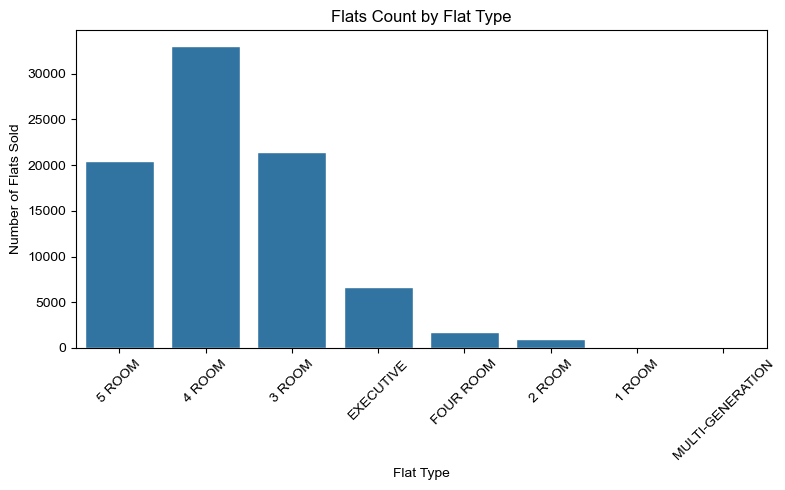

In [17]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.set_style("whitegrid")
sns.countplot(data=df, x='flat_type')

ax.set_title('Flats Count by Flat Type')
ax.set_xlabel('Flat Type')
ax.set_ylabel('Number of Flats Sold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [18]:
df.flat_type.unique()

array(['5 ROOM', '4 ROOM', '3 ROOM', 'EXECUTIVE', 'FOUR ROOM', '2 ROOM',
       '1 ROOM', 'MULTI-GENERATION'], dtype=object)

**`4 ROOM` and `FOUR ROOM` has duplicate names. Need to replace them.**

In [19]:
df.flat_type = df.flat_type.replace('FOUR ROOM', '4 ROOM')

In [20]:
df.flat_type.unique()

array(['5 ROOM', '4 ROOM', '3 ROOM', 'EXECUTIVE', '2 ROOM', '1 ROOM',
       'MULTI-GENERATION'], dtype=object)

In [21]:
df.flat_type.value_counts()

flat_type
4 ROOM              34828
3 ROOM              21490
5 ROOM              20449
EXECUTIVE            6685
2 ROOM                944
1 ROOM                 38
MULTI-GENERATION       31
Name: count, dtype: int64

**The most popular resale flat type is `4 ROOM`, follow by `3 ROOM` and `5 ROOM`.**

### Resale Price

In [22]:
# Resale price Date Range
end = df['month'].max() 
start = df['month'].min()
print(f'The resale price data starts from {start} and end on {end}')

The resale price data starts from 2015-01 and end on 2019-06


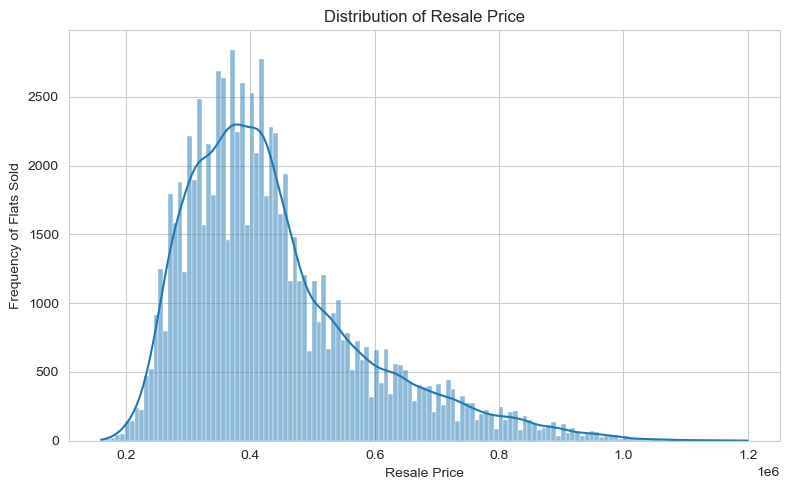

In [23]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.histplot(data=df, x='resale_price', kde=True, ax=ax)

ax.set_title('Distribution of Resale Price')
ax.set_xlabel('Resale Price')
ax.set_ylabel('Frequency of Flats Sold')

plt.tight_layout()
plt.show()

In [24]:
df.describe()

,id,floor_area_sqm,lease_commence_date,resale_price,town_id,flatm_id
count,84465.000000,84465.000000,84465.000000,8.446500e+04,84465.000000,84465.000000
mean,42233.000000,97.518221,1992.312603,4.388110e+05,14.626851,8.886616
std,24383.089581,24.203556,11.728561,1.467822e+05,8.032854,3.905763
min,1.000000,31.000000,1966.000000,1.600000e+05,1.000000,1.000000
25%,21117.000000,76.000000,1984.000000,3.350000e+05,8.000000,5.000000
50%,42233.000000,96.000000,1992.000000,4.080000e+05,15.000000,8.000000
75%,63349.000000,112.000000,2001.000000,5.050000e+05,22.000000,12.000000
max,84465.000000,280.000000,2016.000000,1.200000e+06,26.000000,21.000000


**The mean of resale price is around $438K and the median is around 408K. Resale prices range to $160K to $1.2M. Based on the chart, the distribution of the resale price skewed slightly to the right. This means that there are expensive flat that extends to the right. Lower priced flats are more concentrated.**

In [25]:
skewness = df['resale_price'].skew()
skewness

np.float64(1.2128512245958516)

In [26]:
skewness = df['resale_price'].skew()          # already float
print(f"Skewness of Resale Price: {skewness:.2f}")
if skewness > 0.5: # type: ignore[arg-type]
    print("The distribution is positively skewed.")
elif skewness < -0.5: # type: ignore[arg-type]
    print("The distribution is negatively skewed.")
else:
    print("The distribution is approximately symmetric.")

Skewness of Resale Price: 1.21
The distribution is positively skewed.


**Skewness is more than 1.0, most likely we need to transform the target but we will try to analyze the residual plot first and we will compare performance between transformed target with normal target.**

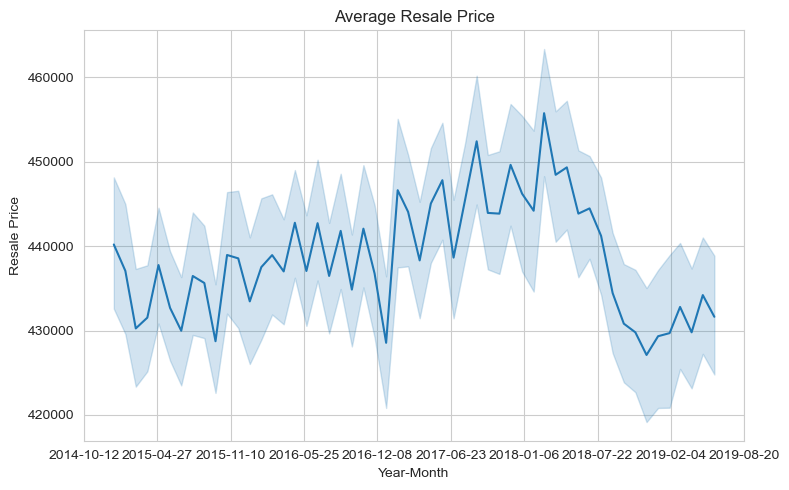

In [27]:
month_dt = pd.to_datetime(df['month'])
df_sorted = df.assign(month_dt=month_dt).sort_values('month_dt')

fig, ax = plt.subplots(figsize=(8,5))  

sns.lineplot(data=df_sorted, x='month_dt', y='resale_price', estimator='mean')

ax.set_title('Average Resale Price')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Resale Price')
ax.xaxis.set_major_locator(ticker.LinearLocator(10))

plt.tight_layout()
plt.show()

**Average resale price varies over the years. This could be due to different flat types and location. It will be more meaningful to explore the average price by flat type. floor area and location.**

### Cyclical Analysis of Resale Transaction

In [28]:
month_counts = df.month.value_counts().sort_index()
month_counts.head()

month
2015-01    1173
2015-02    1085
2015-03    1272
2015-04    1540
2015-05    1470
Name: count, dtype: int64

/var/folders/s3/29d7926n31b40hc3rtxz_m_w0000gq/T/ipykernel_4796/1459698620.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


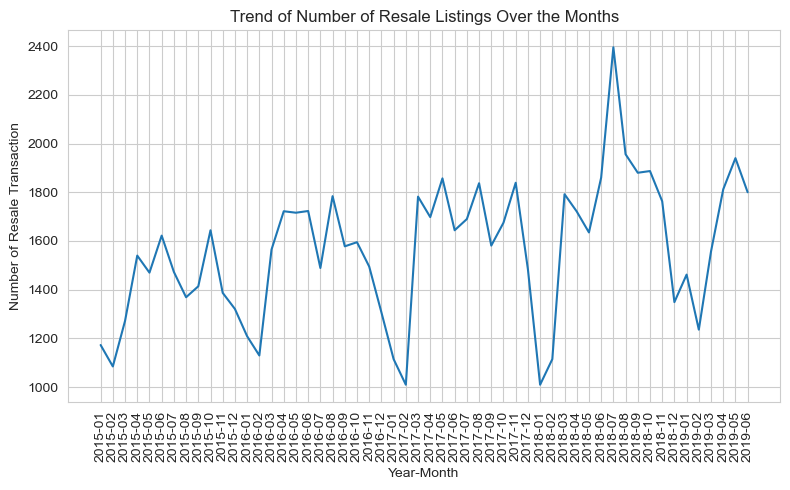

In [29]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.lineplot(x=month_counts.index, y=month_counts.values, ax=ax)

ax.set_title('Trend of Number of Resale Listings Over the Months')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Number of Resale Transaction')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

**HDB resale is seasonal and the month of February has the lowers resale transaction.**

### Million Dollar HDB

In [30]:
# Extract resale price that is more than 1 million excluding 2016
df_high_price = df[df['resale_price'] > 1000000].copy()

# add year column 
df_high_price['year'] = pd.to_datetime(df_high_price['month']).dt.year
df_high_price = df_high_price[df_high_price['year'] != 2019]

# print the number of flats with resale price above 1 million
print(f"Number of flats with resale price above 1 million: {len(df_high_price)}")

# calculate the percentage of high resale price flats against total flats
high_price_percentage = (len(df_high_price) / len(df)) * 100
print(f"Percentage of flats with resale price above 1 million: {high_price_percentage:.2f}%") 

Number of flats with resale price above 1 million: 125
Percentage of flats with resale price above 1 million: 0.15%


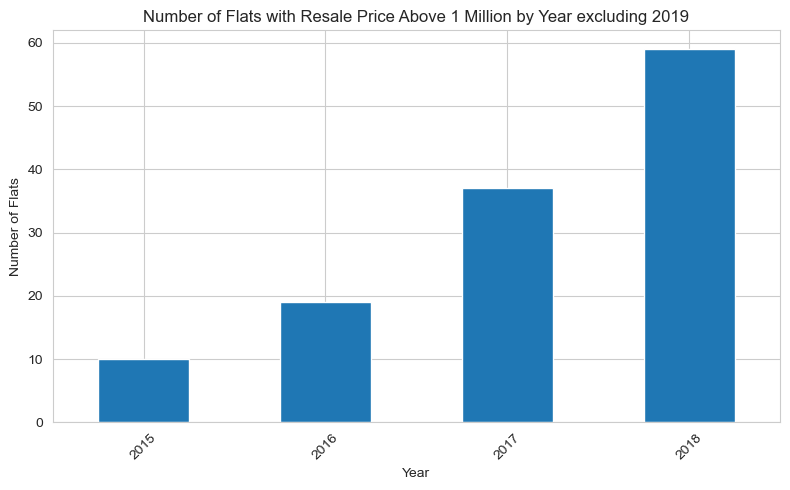

In [31]:
# plot the distribution of resale price to see total number of high price flats for every year
df_high_price['year'].value_counts().sort_index()
df_high_price['year'].value_counts().sort_index().plot(kind='bar', figsize=(8,5))
plt.title('Number of Flats with Resale Price Above 1 Million by Year excluding 2019')
plt.xlabel('Year')
plt.ylabel('Number of Flats')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Town 

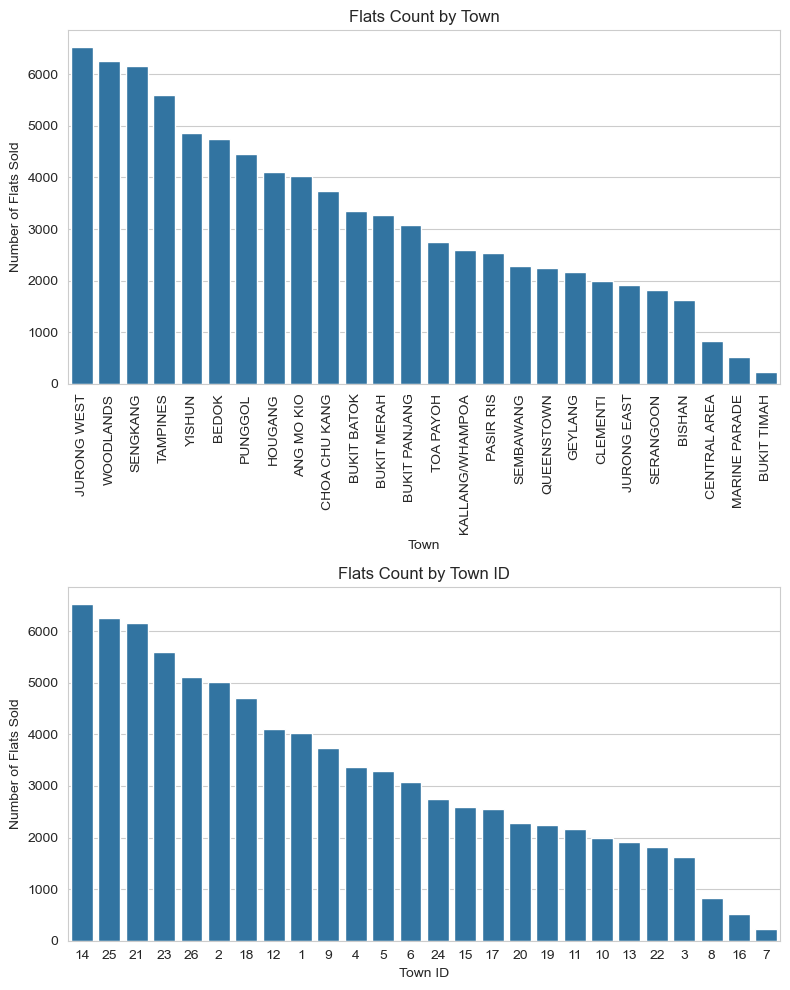

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10))  
sns.set_style("whitegrid")

sorted_town_name = df.town_name.value_counts()
sorted_town_name_index = sorted_town_name.index
sns.countplot(data=df, x='town_name', order=sorted_town_name_index, ax=ax1)

ax1.set_title('Flats Count by Town')
ax1.set_xlabel('Town')
ax1.set_ylabel('Number of Flats Sold')
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation = 90)


sorted_town_id = df.town_id.value_counts()
sorted_town_id_index = sorted_town_id.index
sns.countplot(data=df, x='town_id', order=sorted_town_id_index, ax=ax2)

ax2.set_title('Flats Count by Town ID')
ax2.set_xlabel('Town ID')
ax2.set_ylabel('Number of Flats Sold')

plt.tight_layout()
plt.show()

**It seems that town name and town id correspond with each other.**

In [33]:
np.c_[sorted_town_name.index, sorted_town_id.index, sorted_town_name, sorted_town_id]

array([['JURONG WEST', 14, 6525, 6525],
       ['WOODLANDS', 25, 6264, 6264],
       ['SENGKANG', 21, 6164, 6164],
       ['TAMPINES', 23, 5606, 5606],
       ['YISHUN', 26, 4870, 5111],
       ['BEDOK', 2, 4753, 5009],
       ['PUNGGOL', 18, 4463, 4707],
       ['HOUGANG', 12, 4105, 4105],
       ['ANG MO KIO', 1, 4022, 4022],
       ['CHOA CHU KANG', 9, 3732, 3732],
       ['BUKIT BATOK', 4, 3360, 3360],
       ['BUKIT MERAH', 5, 3282, 3282],
       ['BUKIT PANJANG', 6, 3077, 3077],
       ['TOA PAYOH', 24, 2745, 2745],
       ['KALLANG/WHAMPOA', 15, 2596, 2596],
       ['PASIR RIS', 17, 2544, 2544],
       ['SEMBAWANG', 20, 2291, 2291],
       ['QUEENSTOWN', 19, 2237, 2237],
       ['GEYLANG', 11, 2173, 2173],
       ['CLEMENTI', 10, 1984, 1984],
       ['JURONG EAST', 13, 1911, 1911],
       ['SERANGOON', 22, 1819, 1819],
       ['BISHAN', 3, 1631, 1631],
       ['CENTRAL AREA', 8, 827, 827],
       ['MARINE PARADE', 16, 512, 512],
       ['BUKIT TIMAH', 7, 231, 231]], dtype=object

**Base on the table above, we know that YISHUN, BEDOK abd PUNGGOL missing town name can be filled by using corresponding town id.** 

In [34]:
town_name = sorted_town_name.index.to_list()
town_id = sorted_town_id.index.to_list()
town_name_mapping = dict(zip(town_id, town_name))
town_name_mapping

{14: 'JURONG WEST',
 25: 'WOODLANDS',
 21: 'SENGKANG',
 23: 'TAMPINES',
 26: 'YISHUN',
 2: 'BEDOK',
 18: 'PUNGGOL',
 12: 'HOUGANG',
 1: 'ANG MO KIO',
 9: 'CHOA CHU KANG',
 4: 'BUKIT BATOK',
 5: 'BUKIT MERAH',
 6: 'BUKIT PANJANG',
 24: 'TOA PAYOH',
 15: 'KALLANG/WHAMPOA',
 17: 'PASIR RIS',
 20: 'SEMBAWANG',
 19: 'QUEENSTOWN',
 11: 'GEYLANG',
 10: 'CLEMENTI',
 13: 'JURONG EAST',
 22: 'SERANGOON',
 3: 'BISHAN',
 8: 'CENTRAL AREA',
 16: 'MARINE PARADE',
 7: 'BUKIT TIMAH'}

In [35]:
df.loc[df.town_name.isnull(),'town_id'].map(town_name_mapping)

113        BEDOK
154        BEDOK
249        BEDOK
578        BEDOK
809       YISHUN
          ...   
84142    PUNGGOL
84190      BEDOK
84261     YISHUN
84425     YISHUN
84433      BEDOK
Name: town_id, Length: 741, dtype: object

In [36]:
df.loc[df.town_name.isnull(), 'town_name'] = df.loc[df.town_name.isnull(),'town_id'].map(town_name_mapping)

In [37]:
df.isnull().sum()

id                       0
month                    0
flat_type                0
block                    0
street_name              0
storey_range             0
floor_area_sqm           0
lease_commence_date      0
remaining_lease          0
resale_price             0
town_id                  0
flatm_id                 0
town_name                0
flatm_name             488
dtype: int64

**Top 3 town with the highest turn over is Jurong West, Woodlands and Sengkang.**

### Flat Model Name 

**There are also missing values in flat model name.**

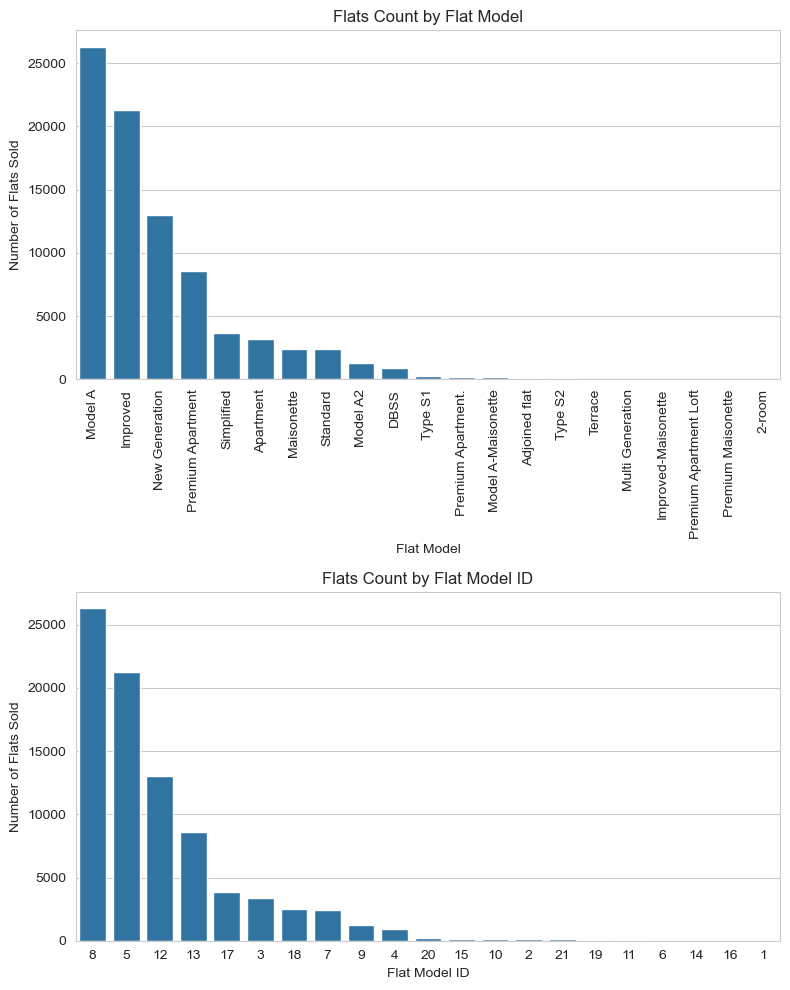

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10))  
sns.set_style("whitegrid")

sorted_flat_model_name = df.flatm_name.value_counts()
sorted_flat_model_index = sorted_flat_model_name.index
sns.countplot(data=df, x='flatm_name', order=sorted_flat_model_index, ax=ax1)

ax1.set_title('Flats Count by Flat Model')
ax1.set_xlabel('Flat Model')
ax1.set_ylabel('Number of Flats Sold')
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation = 90)


sorted_flat_model_id = df.flatm_id.value_counts()
sorted_flat_model_id_index = sorted_flat_model_id.index
sns.countplot(data=df, x='flatm_id', order=sorted_flat_model_id_index, ax=ax2)

ax2.set_title('Flats Count by Flat Model ID')
ax2.set_xlabel('Flat Model ID')
ax2.set_ylabel('Number of Flats Sold')

plt.tight_layout()
plt.show()

In [39]:
np.c_[sorted_flat_model_name.index, sorted_flat_model_id.index, sorted_flat_model_name, sorted_flat_model_id]

array([['Model A', 8, 26281, 26281],
       ['Improved', 5, 21290, 21290],
       ['New Generation', 12, 13023, 13023],
       ['Premium Apartment', 13, 8583, 8583],
       ['Simplified', 17, 3690, 3887],
       ['Apartment', 3, 3223, 3382],
       ['Maisonette', 18, 2433, 2506],
       ['Standard', 7, 2374, 2433],
       ['Model A2', 9, 1254, 1254],
       ['DBSS', 4, 925, 925],
       ['Type S1', 20, 221, 221],
       ['Premium Apartment.', 15, 175, 175],
       ['Model A-Maisonette', 10, 143, 143],
       ['Adjoined flat', 2, 137, 137],
       ['Type S2', 21, 110, 110],
       ['Terrace', 19, 52, 52],
       ['Multi Generation', 11, 31, 31],
       ['Improved-Maisonette', 6, 16, 16],
       ['Premium Apartment Loft', 14, 10, 10],
       ['Premium Maisonette', 16, 5, 5],
       ['2-room', 1, 1, 1]], dtype=object)

**Base on the table above, we can see that `Simplified`, `Apartment`, `Maisonette` and `Standard` flat model name can be filled by corresponding flat model id.**

In [40]:
model_name = sorted_flat_model_name.index.to_list()
model_id = sorted_flat_model_id.index.to_list()
model_name_mapping = dict(zip(model_id, model_name))
model_name_mapping

{8: 'Model A',
 5: 'Improved',
 12: 'New Generation',
 13: 'Premium Apartment',
 17: 'Simplified',
 3: 'Apartment',
 18: 'Maisonette',
 7: 'Standard',
 9: 'Model A2',
 4: 'DBSS',
 20: 'Type S1',
 15: 'Premium Apartment.',
 10: 'Model A-Maisonette',
 2: 'Adjoined flat',
 21: 'Type S2',
 19: 'Terrace',
 11: 'Multi Generation',
 6: 'Improved-Maisonette',
 14: 'Premium Apartment Loft',
 16: 'Premium Maisonette',
 1: '2-room'}

In [41]:
df.loc[df.flatm_name.isnull(),'flatm_id'].map(model_name_mapping)

11        Apartment
24       Simplified
102      Simplified
228      Simplified
276      Maisonette
            ...    
84041    Simplified
84245    Maisonette
84265    Maisonette
84280    Maisonette
84414    Maisonette
Name: flatm_id, Length: 488, dtype: object

In [42]:
df.loc[df.flatm_name.isnull(), 'flatm_name'] = df.loc[df.flatm_name.isnull(),'flatm_id'].map(model_name_mapping)

In [43]:
df.isnull().sum()

id                     0
month                  0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
lease_commence_date    0
remaining_lease        0
resale_price           0
town_id                0
flatm_id               0
town_name              0
flatm_name             0
dtype: int64

**Top 3 model with the most transaction is Model A, Improved and New Generation.**

### Flat Type and Resale Price

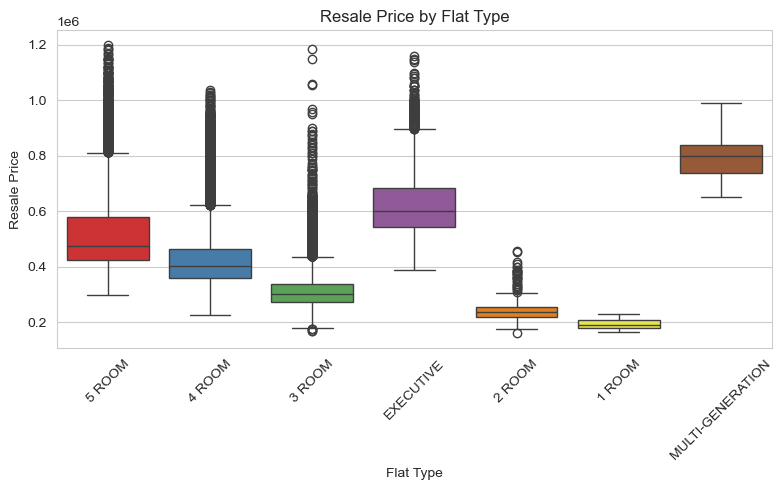

In [44]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.boxplot(data=df, x='flat_type', y='resale_price', hue='flat_type', palette='Set1')

ax.set_title('Resale Price by Flat Type')
ax.set_xlabel('Flat Type')
ax.set_ylabel('Resale Price')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

**There are many outliers for '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', and 'EXECUTIVE' flats. Outliers likely happen maybe due to locations or renovation status.**

### Flat Type and Floor Area

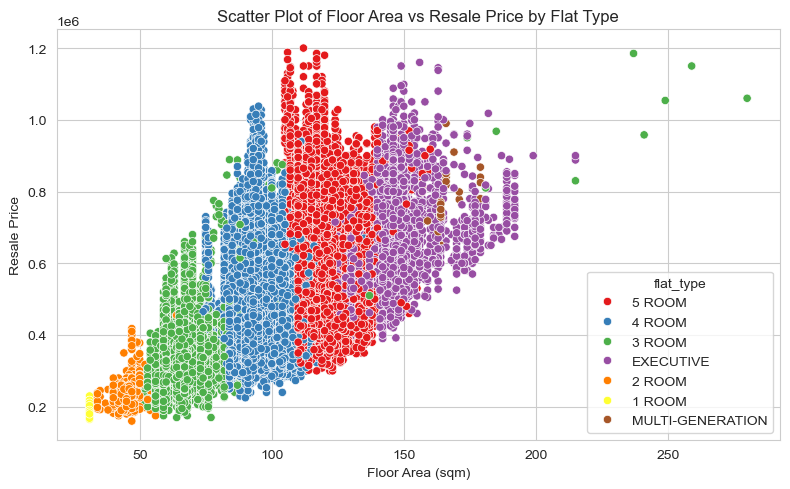

In [45]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.scatterplot(data=df, x='floor_area_sqm', y='resale_price', hue='flat_type', palette='Set1')

ax.set_title('Scatter Plot of Floor Area vs Resale Price by Flat Type')
ax.set_xlabel('Floor Area (sqm)')
ax.set_ylabel('Resale Price')

plt.tight_layout()
plt.show()

**Generally, the increase in floor area result in increase in resale price.**
  
**There are 3 ROOM flats that has a very high selling price and the floor area is also quite high. We need to investigate further.**

In [46]:
outliers_3_room = df[(df['flat_type'] == '3 ROOM') & (df['floor_area_sqm'] > 150) & (df['resale_price'] > 800000)]
outliers_3_room

,id,month,flat_type,block,street_name,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,town_id,flatm_id,town_name,flatm_name
856,857,2018-09,3 ROOM,41,JLN BAHAGIA,01 TO 03,237.0,1972,52 years 10 months,1185000.0,15,19,KALLANG/WHAMPOA,Terrace
7472,7473,2018-06,3 ROOM,58,JLN MA'MOR,01 TO 03,174.0,1972,53 years 02 months,950000.0,15,19,KALLANG/WHAMPOA,Terrace
31858,31859,2015-03,3 ROOM,53,JLN MA'MOR,01 TO 03,280.0,1972,56,1060000.0,15,19,KALLANG/WHAMPOA,Terrace
47739,47740,2017-12,3 ROOM,65,JLN MA'MOR,01 TO 03,249.0,1972,53 years 07 months,1053888.0,15,19,KALLANG/WHAMPOA,Terrace
51992,51993,2018-05,3 ROOM,44,JLN BAHAGIA,01 TO 03,185.0,1972,53 years 02 months,968000.0,15,19,KALLANG/WHAMPOA,Terrace
54578,54579,2016-12,3 ROOM,57,JLN MA'MOR,01 TO 03,259.0,1972,54,1150000.0,15,19,KALLANG/WHAMPOA,Terrace
61997,61998,2017-05,3 ROOM,59,JLN MA'MOR,01 TO 03,181.0,1972,54 years 02 months,810000.0,15,19,KALLANG/WHAMPOA,Terrace
66428,66429,2017-06,3 ROOM,38,JLN BAHAGIA,01 TO 03,215.0,1972,54 years 01 month,830000.0,15,19,KALLANG/WHAMPOA,Terrace
78787,78788,2015-06,3 ROOM,60,JLN BAHAGIA,01 TO 03,241.0,1972,56,958000.0,15,19,KALLANG/WHAMPOA,Terrace


**The outliers are 3 ROOM flats that are built in 1972 where they have floor area of 180 sqm and above. Therefore, flat type is not good enough to differentiate the resale price. Flat model also plays an important differentiator.**

In [47]:
terrace_3_room = df[(df['flat_type'] == '3 ROOM') & (df['flatm_name'] == "Terrace")]
terrace_3_room.describe()

,id,floor_area_sqm,lease_commence_date,resale_price,town_id,flatm_id
count,48.000000,48.000000,48.000000,4.800000e+01,48.000000,48.0
mean,48168.062500,117.708333,1971.333333,8.138407e+05,15.666667,19.0
std,22777.117131,55.604974,1.506487,1.229748e+05,1.506487,0.0
min,857.000000,78.000000,1968.000000,6.350000e+05,15.000000,19.0
25%,31793.750000,83.000000,1972.000000,7.300000e+05,15.000000,19.0
50%,51140.500000,93.000000,1972.000000,7.950000e+05,15.000000,19.0
75%,65752.500000,113.250000,1972.000000,8.712500e+05,15.000000,19.0
max,83890.000000,280.000000,1972.000000,1.185000e+06,19.000000,19.0


- **Terrace was built between 1968 to 1972.**
- **Both floor area and resale price and very wide range.**
- **sqm range from 78 sqm to 280 sqm.**

Checking other similar situation.

In [48]:
df[['flat_type', 'flatm_name', 'floor_area_sqm', 'resale_price']].groupby(['flat_type', 'flatm_name']).mean()

floor_area_sqm  resale_price
flat_type        flatm_name                                          
1 ROOM           Improved                     31.000000  1.921913e+05
2 ROOM           2-room                       55.000000  2.400000e+05
                 DBSS                         50.000000  3.000000e+05
                 Improved                     44.947170  2.335089e+05
                 Maisonette                   45.750000  2.132500e+05
                 Model A                      46.531250  2.544694e+05
                 Premium Apartment            51.777778  2.438889e+05
                 Standard                     44.448161  2.296488e+05
3 ROOM           DBSS                         69.382979  5.684231e+05
                 Improved                     65.247629  3.088092e+05
                 Maisonette                   60.689041  3.039941e+05
                 Model A                      71.762147  3.361815e+05
                 New Generation               69.889765  3.077398e+05
                 Premium Apartment            68.885965  4.168208e+05
                 Premium Apartment.           67.020000  3.262933e+05
                 Simplified                   64.378888  2.970665e+05
                 Standard                     60.713361  3.013912e+05
                 Terrace                     117.708333  8.138407e+05
4 ROOM           Adjoined flat               115.000000  5.693000e+05
                 DBSS                         92.585965  7.208019e+05
                 Improved                     85.139981  4.427535e+05
                 Maisonette                   74.000000  4.800000e+05
                 Model A                      99.243911  4.428593e+05
                 Model A2                     89.000000  3.518922e+05
                 New Generation               93.114968  4.092870e+05
                 Premium Apartment            95.159055  4.360302e+05
                 Premium Apartment.           92.275229  4.693213e+05
                 Simplified                   84.487969  3.653820e+05
                 Standard                     77.710000  4.396296e+05
                 Terrace                     104.500000  8.982500e+05
                 Type S1                      94.334842  8.836077e+05
5 ROOM           Adjoined flat               136.012821  6.731314e+05
                 DBSS                        112.864865  8.463242e+05
                 Improved                    117.894807  5.110667e+05
                 Improved-Maisonette         136.562500  6.806805e+05
                 Maisonette                  117.900000  5.712378e+05
                 Model A                     134.357331  5.502010e+05
                 Model A-Maisonette          141.559441  7.123138e+05
                 Premium Apartment           113.749530  4.653000e+05
                 Premium Apartment Loft      148.000000  8.275576e+05
                 Premium Apartment.          112.250000  6.207430e+05
                 Standard                    118.873684  6.246674e+05
                 Type S2                     106.200000  1.006163e+06
EXECUTIVE        Adjoined flat               161.693878  7.712725e+05
                 Apartment                   143.683028  6.093298e+05
                 Maisonette                  147.964653  6.726485e+05
                 Premium Apartment           133.186275  5.389763e+05
                 Premium Maisonette          173.400000  7.818000e+05
MULTI-GENERATION Multi Generation            163.806452  7.896379e+05

**Besides 3 ROOM flat, other flat type also contains Terrace model. To get a more accurate prediction, flat type and flat model must be used together.**

### Million Dollar HDB

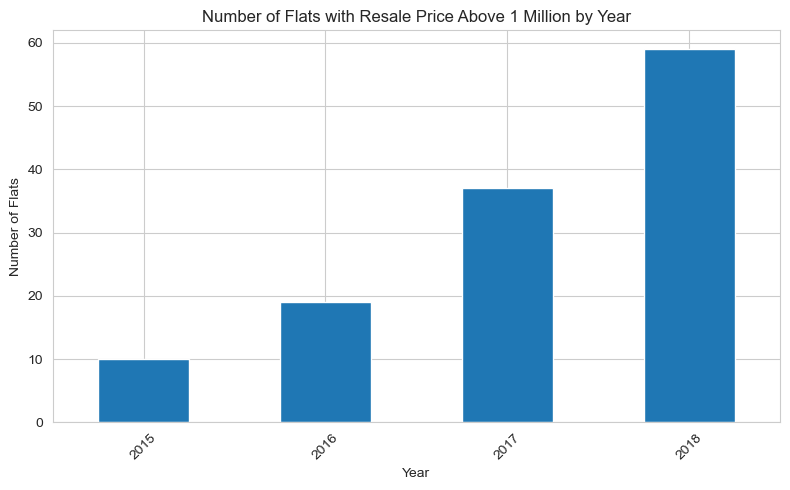

In [49]:

# plot the distribution of resale price to see total number of high price flats for every year
df_high_price['year'] = pd.to_datetime(df_high_price['month']).dt.year
df_high_price['year'].value_counts().sort_index()
df_high_price['year'].value_counts().sort_index().plot(kind='bar', figsize=(8,5))
plt.title('Number of Flats with Resale Price Above 1 Million by Year')
plt.xlabel('Year')
plt.ylabel('Number of Flats')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Average Resale Price By Town, Type and Model Analysis

In [50]:
town_breakdown = df[['town_name', 'floor_area_sqm', 'resale_price']].groupby(['town_name'])
town_breakdown[['floor_area_sqm']].describe()

floor_area_sqm                                             \
                         count        mean        std   min    25%    50%   
town_name                                                                   
ANG MO KIO              4022.0   83.863749  20.456269  44.0   68.0   75.0   
BEDOK                   5009.0   88.574366  24.524571  44.0   67.0   84.0   
BISHAN                  1631.0  106.453709  23.982154  63.0   84.0  105.0   
BUKIT BATOK             3360.0   93.352679  25.126729  59.0   69.0   92.0   
BUKIT MERAH             3282.0   86.194089  23.189514  31.0   67.0   88.0   
BUKIT PANJANG           3077.0  104.375691  19.429658  47.0   92.0  103.0   
BUKIT TIMAH              231.0  109.510823  26.033901  63.0   91.0  104.0   
CENTRAL AREA             827.0   83.192261  18.256195  41.0   67.0   85.0   
CHOA CHU KANG           3732.0  110.504287  18.684382  46.0  103.0  108.0   
CLEMENTI                1984.0   85.174395  21.653877  44.0   67.0   82.0   
GEYLANG                 2173.0   82.613208  26.422782  40.0   60.0   82.0   
HOUGANG                 4105.0  101.353959  24.695735  47.0   84.0  102.0   
JURONG EAST             1911.0   96.522240  25.901695  43.0   72.0   94.0   
JURONG WEST             6525.0  101.965211  22.377951  37.0   90.0  104.0   
KALLANG/WHAMPOA         2596.0   85.967643  24.762917  42.0   65.0   85.0   
MARINE PARADE            512.0   85.763672  22.046668  42.0   65.0   82.0   
PASIR RIS               2544.0  123.160377  18.165887  55.0  106.0  123.0   
PUNGGOL                 4707.0   98.586148  14.026732  46.0   92.0   94.0   
QUEENSTOWN              2237.0   82.360304  22.081808  41.0   65.0   82.0   
SEMBAWANG               2291.0  106.093409  16.589917  40.0   93.0  110.0   
SENGKANG                6164.0  101.003569  16.689848  44.0   92.0   95.0   
SERANGOON               1819.0  100.281473  27.098564  44.0   83.0   99.0   
TAMPINES                5606.0  105.032465  23.905979  45.0   84.0  104.0   
TOA PAYOH               2745.0   85.812022  24.233776  38.0   67.0   78.0   
WOODLANDS               6264.0  107.030651  24.352592  45.0   92.0  103.0   
YISHUN                  5111.0   92.383682  22.944819  40.0   74.0   91.0   

                               
                   75%    max  
town_name                      
ANG MO KIO        92.0  178.0  
BEDOK            105.0  176.0  
BISHAN           121.0  199.0  
BUKIT BATOK      104.0  165.0  
BUKIT MERAH      101.0  157.0  
BUKIT PANJANG    120.0  155.0  
BUKIT TIMAH      126.0  154.0  
CENTRAL AREA      95.0  139.0  
CHOA CHU KANG    122.0  215.0  
CLEMENTI          92.0  163.0  
GEYLANG           95.0  160.0  
HOUGANG          120.0  169.0  
JURONG EAST      120.0  173.0  
JURONG WEST      112.0  159.0  
KALLANG/WHAMPOA  103.0  280.0  
MARINE PARADE     88.0  147.0  
PASIR RIS        143.0  190.0  
PUNGGOL          110.0  149.0  
QUEENSTOWN        95.0  156.0  
SEMBAWANG        113.5  143.0  
SENGKANG         110.0  145.0  
SERANGOON        121.0  165.0  
TAMPINES         122.0  168.0  
TOA PAYOH        104.0  166.0  
WOODLANDS        121.0  192.0  
YISHUN           104.0  181.0

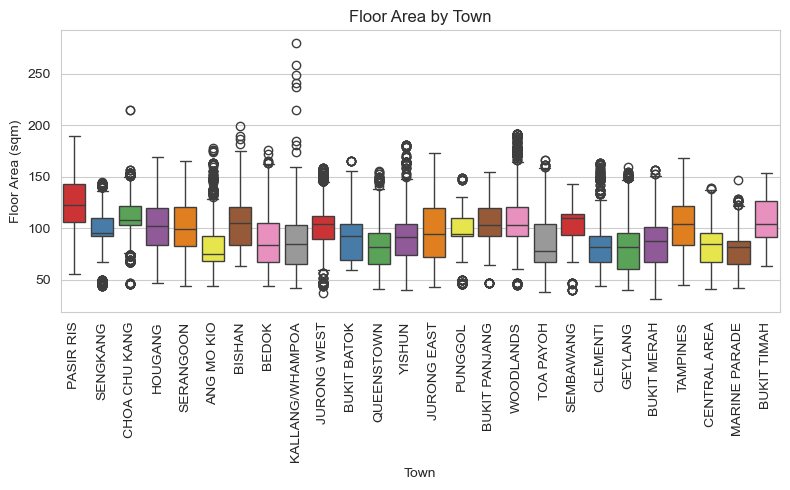

In [51]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.boxplot(data=df, x='town_name', y='floor_area_sqm', hue='town_name', palette='Set1')

ax.set_title('Floor Area by Town')
ax.set_xlabel('Town')
ax.set_ylabel('Floor Area (sqm)')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([label.get_text() for label in ax.get_xticklabels()], rotation=90)

plt.tight_layout()
plt.show()

**The chart shows that some town contains more outliers than other town in terms of floor area. KALLANG/WHAMPOA has many outliers that goes beyond 250 sqm. These are the 3 Room terrace that we discovered earlier.**

In [52]:
town_breakdown[['resale_price']].describe()

resale_price                                          \
                       count           mean            std       min   
town_name                                                              
ANG MO KIO            4022.0  413091.449030  159618.615182  185000.0   
BEDOK                 5009.0  410551.269715  138273.301327  190000.0   
BISHAN                1631.0  629074.109062  177284.876982  239000.0   
BUKIT BATOK           3360.0  383576.468973  121801.546314  210000.0   
BUKIT MERAH           3282.0  555046.925960  199159.555427  165000.0   
BUKIT PANJANG         3077.0  421213.965226  106437.166256  200000.0   
BUKIT TIMAH            231.0  705735.861472  187633.176314  320000.0   
CENTRAL AREA           827.0  648804.414752  246021.437401  215000.0   
CHOA CHU KANG         3732.0  387982.546088   77434.671352  208000.0   
CLEMENTI              1984.0  459870.155746  172758.986267  205000.0   
GEYLANG               2173.0  427308.884031  179865.126414  160000.0   
HOUGANG               4105.0  424142.268395  125641.518241  208000.0   
JURONG EAST           1911.0  422471.756149  140864.832388  200000.0   
JURONG WEST           6525.0  395795.430749   95670.233236  175000.0   
KALLANG/WHAMPOA       2596.0  495478.354730  195861.179035  195000.0   
MARINE PARADE          512.0  535016.492188  179130.426271  180000.0   
PASIR RIS             2544.0  485329.768868   96899.104242  220000.0   
PUNGGOL               4707.0  450954.051974   72557.733677  225000.0   
QUEENSTOWN            2237.0  552433.776433  213721.861521  185000.0   
SEMBAWANG             2291.0  393059.727630   60210.278774  210000.0   
SENGKANG              6164.0  434978.867398   72024.698867  196000.0   
SERANGOON             1819.0  483746.641561  154889.870091  170000.0   
TAMPINES              5606.0  465661.674456  119037.947092  245000.0   
TOA PAYOH             2745.0  480198.537341  221809.213161  170000.0   
WOODLANDS             6264.0  385909.539112   97702.427497  180000.0   
YISHUN                5111.0  358693.446073   92940.870703  195000.0   

                                                          
                      25%       50%       75%        max  
town_name                                                 
ANG MO KIO       300000.0  350000.0  478972.0   980000.0  
BEDOK            300000.0  371000.0  490000.0   935000.0  
BISHAN           507444.0  609000.0  751594.0  1180000.0  
BUKIT BATOK      280000.0  360000.0  444100.0   890000.0  
BUKIT MERAH      365000.0  570000.0  725000.0  1200000.0  
BUKIT PANJANG    340000.0  403000.0  480000.0   840000.0  
BUKIT TIMAH      580000.0  708000.0  857500.0  1058000.0  
CENTRAL AREA     430000.0  570000.0  888000.0  1188000.0  
CHOA CHU KANG    335000.0  370000.0  421000.0   900000.0  
CLEMENTI         323000.0  400000.0  568000.0  1068000.0  
GEYLANG          278000.0  375000.0  565000.0   980000.0  
HOUGANG          336000.0  398000.0  478000.0   908000.0  
JURONG EAST      304500.0  391888.0  513000.0   900000.0  
JURONG WEST      330000.0  390000.0  458000.0   790000.0  
KALLANG/WHAMPOA  328000.0  460000.0  645000.0  1185000.0  
MARINE PARADE    400000.0  475000.0  606000.0   950000.0  
PASIR RIS        410000.0  460000.0  545000.0   808000.0  
PUNGGOL          408000.0  440888.0  488000.0   910888.0  
QUEENSTOWN       350000.0  538000.0  735000.0  1170000.0  
SEMBAWANG        350000.0  385000.0  430000.0   590000.0  
SENGKANG         385000.0  428000.0  475000.0   700000.0  
SERANGOON        363500.0  460000.0  591000.0  1000000.0  
TAMPINES         380000.0  443844.0  530000.0   990000.0  
TOA PAYOH        295000.0  390000.0  651000.0  1160888.0  
WOODLANDS        325000.0  370000.0  420000.0   855000.0  
YISHUN           290000.0  335000.0  400000.0   868000.0

/var/folders/s3/29d7926n31b40hc3rtxz_m_w0000gq/T/ipykernel_4796/1680127105.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


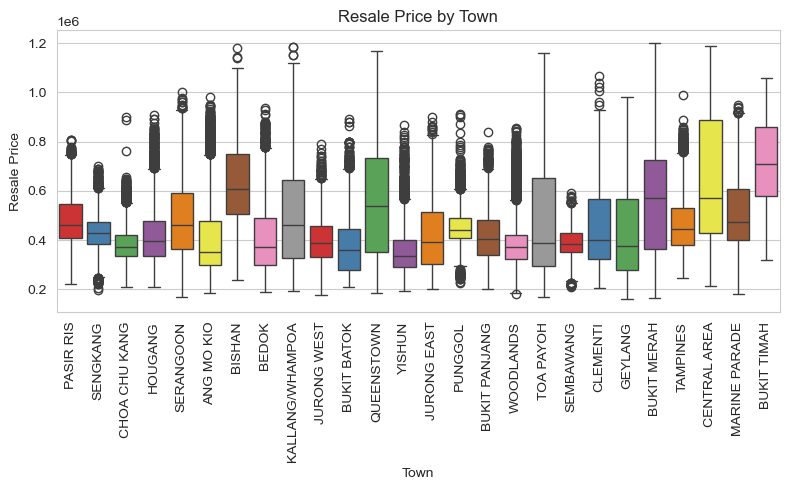

In [53]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.boxplot(data=df, x='town_name', y='resale_price', hue='town_name', palette='Set1')

ax.set_title('Resale Price by Town')
ax.set_xlabel('Town')
ax.set_ylabel('Resale Price')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

**Some town command higher median selling price compared to other town.**

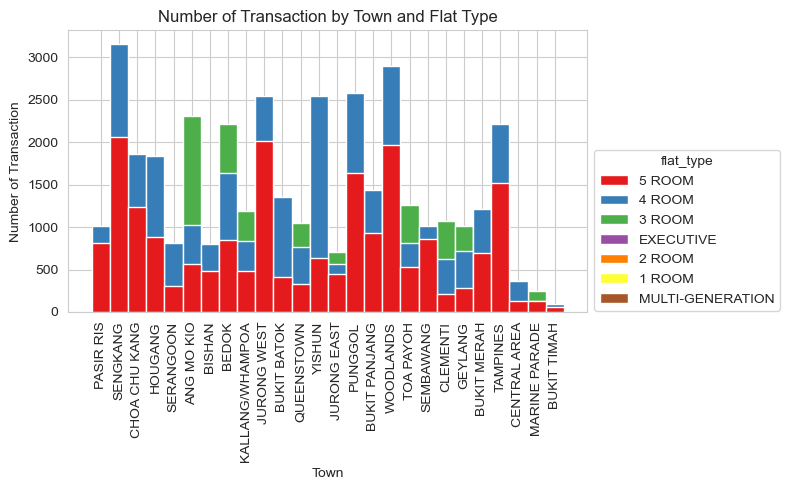

In [54]:
fig, ax = plt.subplots(figsize=(8,5))  

f1 = sns.histplot(data=df, x='town_name', hue='flat_type', palette='Set1', alpha=1)
sns.move_legend(f1, "upper left", bbox_to_anchor=(1, 0.6))

ax.set_title('Number of Transaction by Town and Flat Type')
ax.set_xlabel('Town')
ax.set_ylabel('Number of Transaction')
ax.set_xticks(ax.get_xticks(), [label.get_text() for label in ax.get_xticklabels()], rotation=90)

plt.tight_layout()
plt.show()


**Some flat type such as 3 ROOM is only available for sales in older towns.**

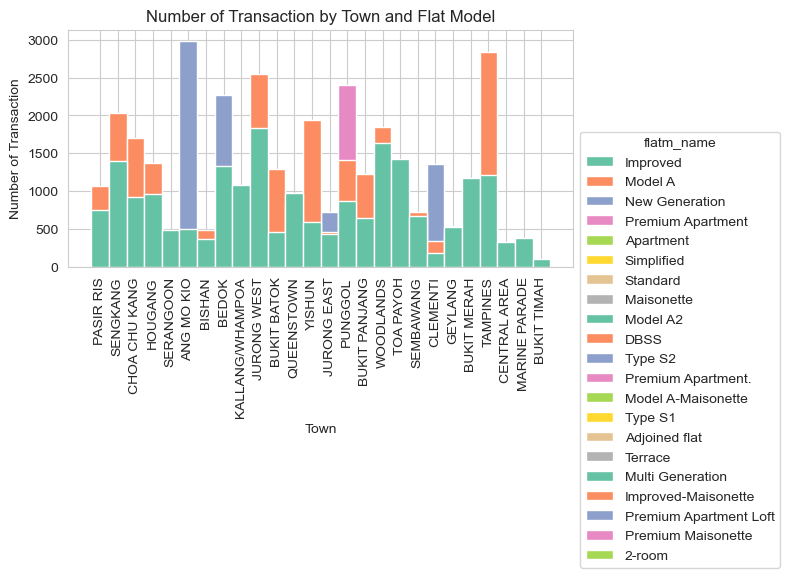

In [55]:
fig, ax = plt.subplots(figsize=(8,5))  

f1 = sns.histplot(data=df, x='town_name', hue='flatm_name', palette='Set2', alpha=1)
sns.move_legend(f1, "upper left", bbox_to_anchor=(1, 0.6))

ax.set_title('Number of Transaction by Town and Flat Model')
ax.set_xlabel('Town')
ax.set_ylabel('Number of Transaction')
ax.set_xticks(ax.get_xticks(), [label.get_text() for label in ax.get_xticklabels()], rotation=90)

plt.tight_layout()
plt.show()

**Some model is only available at some town.**

In [56]:
town_type_breakdown = df[['town_name', 'flat_type', 'floor_area_sqm', 'resale_price']].groupby(['town_name', 'flat_type'])
print(town_type_breakdown[['floor_area_sqm']].describe().to_string())



                                 floor_area_sqm                                                            
                                          count        mean        std    min     25%    50%     75%    max
town_name       flat_type                                                                                  
ANG MO KIO      2 ROOM                     73.0   44.136986   0.346212   44.0   44.00   44.0   44.00   45.0
                3 ROOM                   2305.0   70.813015   5.816136   60.0   67.00   68.0   73.00   89.0
                4 ROOM                   1024.0   93.006836   4.019375   81.0   91.00   92.0   95.00  114.0
                5 ROOM                    570.0  119.012281   7.177258  110.0  112.00  119.0  121.00  150.0
                EXECUTIVE                  50.0  155.560000   9.289362  144.0  148.00  152.5  162.00  178.0
BEDOK           2 ROOM                     75.0   44.773333   0.421495   44.0   45.00   45.0   45.00   45.0
                3 ROOM      

In [57]:
print(town_type_breakdown[['resale_price']].describe().to_string())

                                 resale_price                                                                                   
                                        count           mean            std       min       25%       50%        75%         max
town_name       flat_type                                                                                                       
ANG MO KIO      2 ROOM                   73.0  231705.479452   20577.400565  185000.0  218000.0  233000.0   249000.0   272000.00
                3 ROOM                 2305.0  312003.832104   44113.978734  205000.0  281000.0  307000.0   335000.0   519000.00
                4 ROOM                 1024.0  482285.674805   96520.808064  295000.0  415000.0  453000.0   520000.0   782000.00
                5 ROOM                  570.0  686498.736842  111686.571790  440000.0  600000.0  663944.0   775000.0   980000.00
                EXECUTIVE                50.0  804113.280000   62788.950675  628000.0  777500.0  

**If we breakdown the flat by town and flat type, the dispersion of the floor area and resale price is still wide. But the dispersion of floor area and resale price is narrower compared to just using one classification category. This is due to different flat model.**

In [58]:
full_breakdown = df[['town_name', 'flat_type', 'flatm_name', 'floor_area_sqm', 'resale_price']].groupby(['town_name', 'flat_type', 'flatm_name'])


In [59]:
print(full_breakdown[['floor_area_sqm']].describe().to_string())

                                                        floor_area_sqm                                                            
                                                                 count        mean        std    min     25%    50%     75%    max
town_name       flat_type        flatm_name                                                                                       
ANG MO KIO      2 ROOM           Improved                         73.0   44.136986   0.346212   44.0   44.00   44.0   44.00   45.0
                3 ROOM           Improved                         36.0   62.277778   3.622242   60.0   60.00   60.0   66.00   69.0
                                 Model A                          45.0   70.000000   0.000000   70.0   70.00   70.0   70.00   70.0
                                 New Generation                 2224.0   70.967626   5.799688   67.0   67.00   68.0   73.00   89.0
                4 ROOM           DBSS                             54.0   90.537037 

In [60]:
print(full_breakdown[['resale_price']].describe().to_string())

                                                        resale_price                                                                                  
                                                               count          mean            std       min       25%       50%        75%         max
town_name       flat_type        flatm_name                                                                                                           
ANG MO KIO      2 ROOM           Improved                       73.0  2.317055e+05   20577.400565  185000.0  218000.0  233000.0   249000.0   272000.00
                3 ROOM           Improved                       36.0  2.701962e+05   23954.129688  230000.0  257250.0  274000.0   280000.0   330000.00
                                 Model A                        45.0  4.576197e+05   28938.754065  380000.0  445000.0  460000.0   475000.0   519000.00
                                 New Generation               2224.0  3.097342e+05   39097.977

**If we breakdown the flat by town, flat type and flat model, for some location, there is no dispersion. However for some location, the dispersion of the floor area and resale price is much narrower compared to previous grouping and classification. However, some flat model still present a slightly wide dispersion in terms of flat model and resale price.**

In [61]:
group_flat_model_sqm = df[['flat_type', 'flatm_name', 'floor_area_sqm', 'resale_price']].groupby(['flat_type', 'flatm_name', 'floor_area_sqm']).mean()
print(group_flat_model_sqm.to_string())

                                                        resale_price
flat_type        flatm_name             floor_area_sqm              
1 ROOM           Improved               31.0            1.921913e+05
2 ROOM           2-room                 55.0            2.400000e+05
                 DBSS                   50.0            3.000000e+05
                 Improved               40.0            2.327143e+05
                                        41.0            2.123333e+05
                                        42.0            1.800000e+05
                                        43.0            2.380000e+05
                                        44.0            2.329971e+05
                                        45.0            2.335671e+05
                                        46.0            2.430000e+05
                                        53.0            2.563750e+05
                                        54.0            2.366000e+05
                                  

**Even if we fine tuned the flat selection by model type, there are many variation in terms of floor area. For example, in a 5 Room Model A flat we have a range of 129 sqm to 157 sqm. This proves that if we narrow our selection to model type, we may not have accurate prediction without the indication of floor area.**

**Our initial conclusion is that the best feature to predict housing price is the floor area. However, we will keep the flat type and flat model to provide us segmentation information so that we can improve the prediction of resale price.**

### Selected Break Down of Resale Price

#### 4 ROOM with Model A by Town

In [62]:
four_model_A = df.loc[(df['flat_type']=='4 ROOM') & (df['flatm_name']=='Model A'),['town_name', 'floor_area_sqm', 'resale_price']]

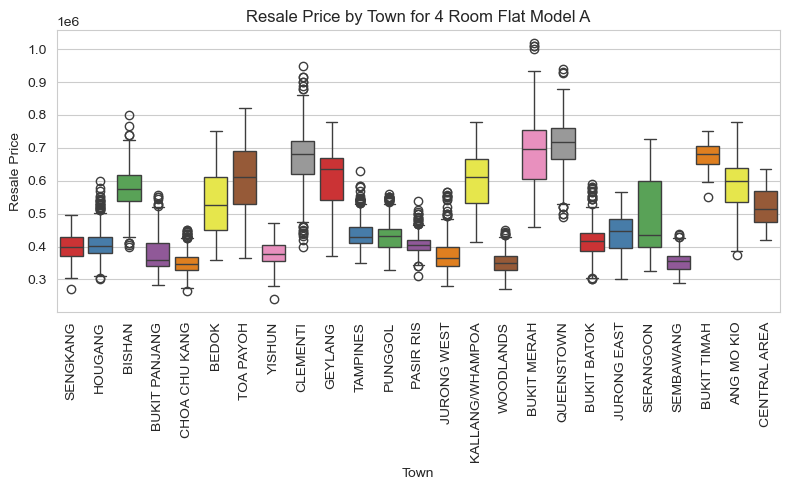

In [63]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.boxplot(data=four_model_A, x='town_name', y='resale_price', hue='town_name', palette='Set1')

ax.set_title('Resale Price by Town for 4 Room Flat Model A')
ax.set_xlabel('Town')
ax.set_ylabel('Resale Price')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([label.get_text() for label in ax.get_xticklabels()], rotation=90)

plt.tight_layout()
plt.show()

**The more we breakdown by town, flat type and flat model, the less dispersion is the resale price. However, it is clear that not every town command the same resale price for the same type of flat with the same model.**

### Remaining Lease

In [64]:
df.remaining_lease.unique()

array(['70 years 03 months', '81', '82 years 06 months', '67',
       '74 years 02 months', '61 years 04 months', '74 years 01 month',
       '63 years 08 months', '66 years', '85', '58 years 11 months', '68',
       '59', '71', '94 years 07 months', '92', '50 years 09 months',
       '72 years 04 months', '86', '70', '47 years 09 months', '82',
       '94 years 05 months', '72 years 07 months', '93',
       '76 years 01 month', '53', '90 years 04 months',
       '57 years 09 months', '68 years 03 months', '73 years 07 months',
       '79 years 10 months', '83 years 02 months', '94 years 02 months',
       '77', '58 years 09 months', '65 years 10 months',
       '65 years 01 month', '67 years 08 months', '61',
       '84 years 10 months', '63', '72', '81 years 08 months',
       '57 years 04 months', '80 years 07 months', '83 years 01 month',
       '60', '95 years 05 months', '65 years', '84', '66',
       '84 years 03 months', '78 years 03 months', '63 years 03 months',
       '76', 

**Remaining lease is either in year or in year and month. We assume numbers without indicating month or year belongs to year.** 

In [65]:
df.remaining_lease.isnull().sum()

np.int64(0)

**We need to convert the remaining lease to months as a standard indicator.**

In [66]:
def convert_lease_to_month(lease):
    """
    Convert remaining lease period from string to total number of months.
    Args:
        remaining_lease in (str)

    Returns: 
        integer

    Example:
        convert_lease_to_month('07 TO 09') -> 8.0  
    """
    str_list = lease.split(' ')
    if ('months' in str_list) | ('month' in str_list):
        year = int(str_list[0])
        month = int(str_list[2])
        t_month = (year * 12) + month 
    elif ('years' in str_list) & (('months' not in str_list) | ('month' not in str_list)):
        year = int(str_list[0])
        t_month = (year * 12)
    else:
        year = int(str_list[0])
        t_month = (year * 12)        
    return t_month

In [67]:
df['remaining_lease_by_month'] = df.remaining_lease.apply(convert_lease_to_month)

### Correlation Analysis

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84465 entries, 0 to 84464
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        84465 non-null  int64  
 1   month                     84465 non-null  object 
 2   flat_type                 84465 non-null  object 
 3   block                     84465 non-null  object 
 4   street_name               84465 non-null  object 
 5   storey_range              84465 non-null  object 
 6   floor_area_sqm            84465 non-null  float64
 7   lease_commence_date       84465 non-null  int64  
 8   remaining_lease           84465 non-null  object 
 9   resale_price              84465 non-null  float64
 10  town_id                   84465 non-null  int64  
 11  flatm_id                  84465 non-null  int64  
 12  town_name                 84465 non-null  object 
 13  flatm_name                84465 non-null  object 
 14  remaining_l

In [69]:
corr_column = df[['floor_area_sqm', 'lease_commence_date', 'remaining_lease_by_month', 'resale_price']]
corr_matrix_pear = corr_column.corr(method='pearson')
corr_matrix_pear

,floor_area_sqm,lease_commence_date,remaining_lease_by_month,resale_price
floor_area_sqm,1.000000,0.296933,0.298915,0.640309
lease_commence_date,0.296933,1.000000,0.995243,0.340613
remaining_lease_by_month,0.298915,0.995243,1.000000,0.342304
resale_price,0.640309,0.340613,0.342304,1.000000


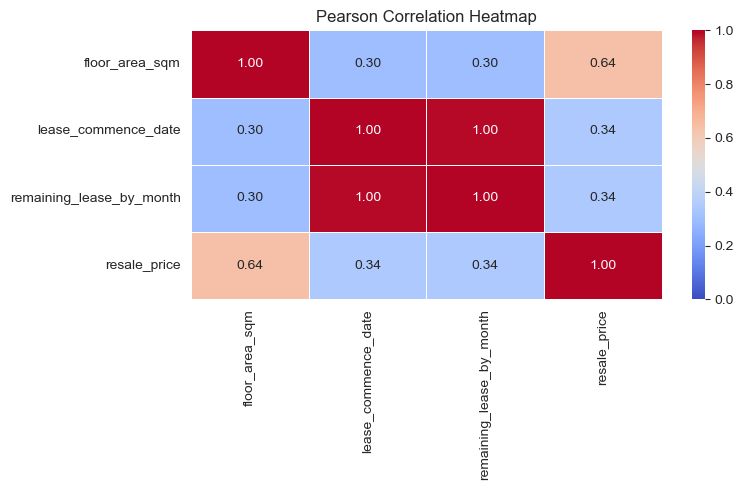

In [70]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.heatmap(corr_matrix_pear, annot=True, cmap='coolwarm', vmin=0, center=0.5, vmax=1, linewidths=0.5, fmt=".2f")

ax.set_title('Pearson Correlation Heatmap')

plt.tight_layout()
plt.show()

**There is a strong correlation between floor area and resale price. There is also moderate correlation between resale price and lease commence date which in turn indicating the age of the flat. The features, lease commence date and remaining lease in months are highly correlated. Therefore, it is suggested that we either use Ridge Regression to reduce the impact of multicollinearity or we drop one of the feature.** 

In [71]:
df.head()

,id,month,flat_type,block,street_name,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,town_id,flatm_id,town_name,flatm_name,remaining_lease_by_month
0,1,2018-05,5 ROOM,118,PASIR RIS ST 11,07 TO 09,123.0,1989,70 years 03 months,488000.0,17,5,PASIR RIS,Improved,843
1,2,2016-10,4 ROOM,101,RIVERVALE WALK,01 TO 03,100.0,1999,81,345000.0,21,8,SENGKANG,Model A,972
2,3,2018-10,5 ROOM,688A,CHOA CHU KANG DR,19 TO 21,110.0,2002,82 years 06 months,370000.0,9,5,CHOA CHU KANG,Improved,990
3,4,2015-12,4 ROOM,130,LOR AH SOO,13 TO 15,103.0,1984,67,432000.0,12,8,HOUGANG,Model A,804
4,5,2017-09,5 ROOM,533,SERANGOON NTH AVE 4,07 TO 09,122.0,1992,74 years 02 months,500000.0,22,5,SERANGOON,Improved,890


**We will convert the storey range to numeric and the take the middle floor indicated by the storey range. For example, if storey range is from 7th floor to 9th floor. We will take the middle floor, 8th floor as the indicator.**

In [72]:
def convert_storey_range(storey_range):
    """
    Convert storey range to the numerical average.
    Args:
        storey_range in (str)

    Returns: 
        float

    Example:
        convert_storey_range('07 TO 09') -> 8.0 
    """

    low, high = storey_range.split(' TO ')
    average = (int(low) + int(high)) / 2
    return average

In [73]:
df.storey_range = df.storey_range.apply(convert_storey_range)

In [74]:
df.storey_range

0         8.0
1         2.0
2        20.0
3        14.0
4         8.0
         ... 
84460    11.0
84461     8.0
84462     2.0
84463     2.0
84464    14.0
Name: storey_range, Length: 84465, dtype: float64

In [75]:
spearman_col = df[['storey_range', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease_by_month', 'resale_price']]
spearman_corr = spearman_col.corr(method='spearman')

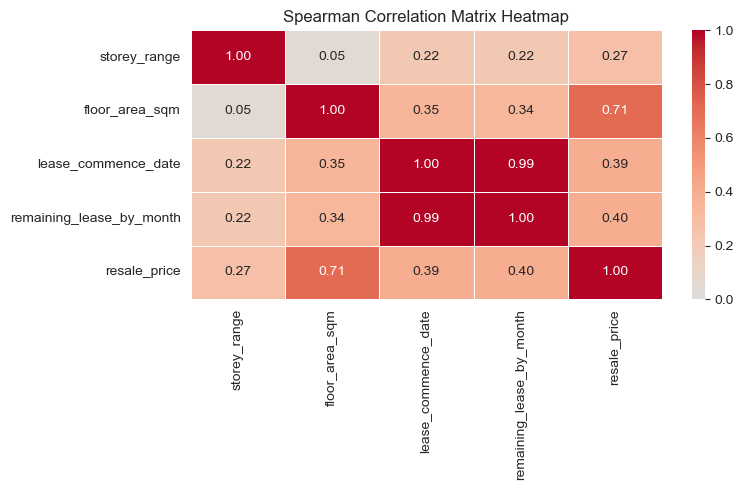

In [76]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=0, center=0, vmax=1, linewidths=0.5, fmt=".2f")

ax.set_title('Spearman Correlation Matrix Heatmap')

plt.tight_layout()
plt.show()

**There is strong correlation between floor area and resale price. Moderate correlation between age of the flat and the resale price. Moderate to weak correlation between height of the flat and resale price. Similarly, there is high correlation between lease commence date and remaining lease in months. Remaining lease in months are slightly more correlated to the resale price, as it is more granular. Therefore, we can consider dropping lease commence date if necessary.**

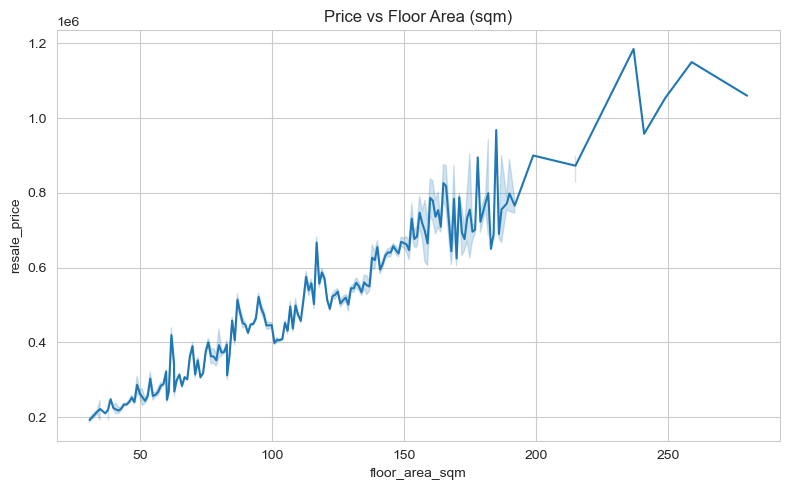

In [77]:
fig, ax = plt.subplots(figsize=(8,5))  

sns.lineplot(df, x = df.floor_area_sqm, y=df.resale_price)

ax.set_title('Price vs Floor Area (sqm)')

plt.tight_layout()
plt.show()

**There is a linear trend in terms of resale price and its biggest contributor.**

## EDA Findings

**Resale Price**
- **The mean of resale price is around $438K and the median is around 408K. Resale prices range from $160K to $1.2M. Based on the chart, the distribution of the resale price skewed to the right. This means that there are expensive flat that extends to the right. Lower priced flats are more concentrated. The skewness will cause the model to over-estimate the normal range houses. Either we use transformation on the target or we use other model that are robust to the skewness.**

**Feature Analysis**
- **Top 3 town with the highest turn over is Jurong West, Woodlands and Sengkang. The most popular resale flat type is 4 ROOM, follow by 3 ROOM and 5 ROOM flat. Top 3 model with the most transaction is Model A, Improved and New Generation.**
- **For 3 ROOM flats, there are outliers. These outliers belongs to old 3 ROOM flat that comes with a Terrace model. These flats are built between 1968 and 1972. The floor area ranges from 78 sqm to 880 sqm. Therefore, flat type is not good enough to differentiate the resale price. Flat model also plays an important differentiator.**
- **Besides 3 ROOM flat, other flat type also contains Terrace model. To get a more accurate prediction, flat type and flat model must be used together.**
- **Some flat type such as 3 ROOM is only available at older towns. Some model such as 'New Generation' is only available at some town.**
- **For the same flat type with the same model and similar floor area, not every town command the similar resale price range. Some town has higher median resale price compared to other town. This proves that location matters.**
- **If we breakdown the flat by town, flat type and flat model, for some location, there is no dispersion. However for some location, the dispersion of the floor area and resale price is much narrower compared to fewer grouping. However, some flat model still present a slightly wide dispersion in terms of flat model and resale price.**
- **Even if we fine tuned the flat selection by model type, there are many variation in terms of floor area. For example, in a 5 Room Model A flat we have a range of floor area between 129 sqm to 157 sqm. This proves that if we narrow our selection to flat type and model type, we may not have accurate prediction without the indication of floor area.**

**Feature Analysis Conclusion** 
- **Our initial conclusion is that the best feature to predict housing price is the floor area. However, we will can keep the flat type and flat model to provide us segmentation information so that we can improve the prediction of resale price. Location information is important to differentiate the price in different town.**

**Correlation Analysis**
- **For Pearson correlation analysis, there is a strong correlation between floor area and resale price. There is also moderate correlation between resale price and lease commence date which in turn indicating the age of the flat. The features, lease commence date and remaining lease in months are highly correlated. Therefore, it is suggested that we either use Ridge Regression to reduce the impact of multicollinearity or we drop one of the feature.** 
- **For Spearman Correlation Analysis, there is strong correlation between floor area and resale price. Moderate correlation between age of the flat and the resale price. Moderate to weak correlation between height of the flat and resale price. Similarly, there is high correlation between lease commence date and remaining lease in months. Remaining lease in months are slightly more correlated to the resale price, as it is more granular. Therefore, we can consider dropping lease commence date if necessary.**
- **Additional chart show a linear relation between hdb resale price and the floor area.**

### Conclusion

- **Floor area is the most important feature follow by age of the flat and the height of the flat.**
- **For the age of the flat, we will drop the column `lease_commence_date` and keep `remaining_lease_by_month`.** 
- **Other factor that are not in correlation analysis such as location information (`town_name`) also provide important signal on pricing prediction.**
- **We will keep the `flat_type` and `flatm_name` (flat model) to improve the prediction by providing segmental information.**
- **Investigation in our EDA suggested that there are many variation in `flat_type`. For example, a 3-room flat, the floor area ranges from 78sqm to 280 sqm. Therefore, we think that `flat_type` should be nominal instead of ordinal.**
- **Lastly, we will keep transaction year and month, to help with the seasonal resale price prediction.**

## Data Cleaning

In [78]:
# Load the dataset
df = pd.read_csv('./data/resale_transactions.csv')

In [79]:
len(df)

88688

### Removing Duplicates

In [80]:
# Remove duplicated items
df.drop_duplicates(inplace=True)

In [81]:
df.duplicated().sum()

np.int64(0)

In [82]:
len(df)

84465

### Handling Negatives Value

In [83]:
# Remove negative number in lease commence date
df.lease_commence_date = df.lease_commence_date.abs()

In [84]:
df.describe()

,id,floor_area_sqm,lease_commence_date,resale_price,town_id,flatm_id
count,84465.000000,84465.000000,84465.000000,8.446500e+04,84465.000000,84465.000000
mean,42233.000000,97.518221,1992.312603,4.388110e+05,14.626851,8.886616
std,24383.089581,24.203556,11.728561,1.467822e+05,8.032854,3.905763
min,1.000000,31.000000,1966.000000,1.600000e+05,1.000000,1.000000
25%,21117.000000,76.000000,1984.000000,3.350000e+05,8.000000,5.000000
50%,42233.000000,96.000000,1992.000000,4.080000e+05,15.000000,8.000000
75%,63349.000000,112.000000,2001.000000,5.050000e+05,22.000000,12.000000
max,84465.000000,280.000000,2016.000000,1.200000e+06,26.000000,21.000000


### Standardizing Categorical Labels

In [85]:
df.flat_type = df.flat_type.replace('FOUR ROOM', '4 ROOM')

In [86]:
df.flat_type.unique()

array(['5 ROOM', '4 ROOM', '3 ROOM', 'EXECUTIVE', '2 ROOM', '1 ROOM',
       'MULTI-GENERATION'], dtype=object)

### Handling Missing Values

In [87]:
def handling_missing_name(df: pd.DataFrame, missing_name_col: str, missing_name_related_id_col:str) -> pd.DataFrame:
    """ 
    Fills missing values in the 'name' column from the 'id' column.

        Args:
        -----
        df (pd.DataFrame): The DataFrame containing the columns to be fixed.
        missing_name_related_id_col (str): The name of the column containing the IDs that matches the name.
        missing_name_col (str): The name of the column containing missing names to be filled.

        Returns:
        --------
        pd.DataFrame: The DataFrame with missing values fixed.
    """

    missing_name_rows = df[missing_name_col].isnull()
    list_name = df[missing_name_col].value_counts().index.to_list()
    list_id = df[missing_name_related_id_col].value_counts().index.to_list()

    missing_name_mapping = dict(zip(list_id, list_name))
    #print(missing_name_mapping)
    
    df.loc[missing_name_rows, missing_name_col] = df.loc[missing_name_rows, missing_name_related_id_col].map(missing_name_mapping)

    return df

In [88]:
# Fill missing values in 'town_name' column
df = handling_missing_name(df, missing_name_col='town_name', missing_name_related_id_col='town_id')

# Fill missing values in 'flatm_name' column
df = handling_missing_name(df=df, missing_name_related_id_col='flatm_id', missing_name_col='flatm_name')

In [89]:
df.isnull().sum()

id                     0
month                  0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
lease_commence_date    0
remaining_lease        0
resale_price           0
town_id                0
flatm_id               0
town_name              0
flatm_name             0
dtype: int64

In [90]:
len(df)

84465

## Feature Engineering

### Feature Engineering - Splitting Transaction Column 'month' to Year and Month

In [91]:
# Splitting column 'month' into year and month
df['year_month'] = pd.to_datetime(df.month, format='%Y-%m')
df['transac_year'] = df.year_month.dt.year
df['transac_month'] = df.year_month.dt.month

In [92]:
df.head()

,id,month,flat_type,block,street_name,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,town_id,flatm_id,town_name,flatm_name,year_month,transac_year,transac_month
0,1,2018-05,5 ROOM,118,PASIR RIS ST 11,07 TO 09,123.0,1989,70 years 03 months,488000.0,17,5,PASIR RIS,Improved,2018-05-01,2018,5
1,2,2016-10,4 ROOM,101,RIVERVALE WALK,01 TO 03,100.0,1999,81,345000.0,21,8,SENGKANG,Model A,2016-10-01,2016,10
2,3,2018-10,5 ROOM,688A,CHOA CHU KANG DR,19 TO 21,110.0,2002,82 years 06 months,370000.0,9,5,CHOA CHU KANG,Improved,2018-10-01,2018,10
3,4,2015-12,4 ROOM,130,LOR AH SOO,13 TO 15,103.0,1984,67,432000.0,12,8,HOUGANG,Model A,2015-12-01,2015,12
4,5,2017-09,5 ROOM,533,SERANGOON NTH AVE 4,07 TO 09,122.0,1992,74 years 02 months,500000.0,22,5,SERANGOON,Improved,2017-09-01,2017,9


### Feature Engineering - Convert 'remaining_lease' to remaining_lease_months'

In [93]:
def convert_lease_to_month(lease: str) -> int:
    """
    Convert remaining lease period from string to total number of months.
    Args:
        remaining_lease in (str)

    Returns: 
        integer

    Example:
        convert_lease_to_month('07 TO 09') -> 8.0  
    """
    str_list = lease.split(' ')
    if ('months' in str_list) | ('month' in str_list):
        year = int(str_list[0])
        month = int(str_list[2])
        total_month = (year * 12) + month 
    elif ('years' in str_list) & (('months' not in str_list) | ('month' not in str_list)):
        year = int(str_list[0])
        total_month = (year * 12)
    else:
        year = int(str_list[0])
        total_month = (year * 12)        
    return total_month

In [94]:
# Convert column remaining lease to remaining lease by  months
df['remaining_lease_by_months'] = df.remaining_lease.apply(convert_lease_to_month)


In [95]:

df[['remaining_lease', 'remaining_lease_by_months']].sample(10)

,remaining_lease,remaining_lease_by_months
53245,68,816
82366,62,744
56268,71,852
50600,65 years 03 months,783
67879,84 years 05 months,1013
47776,73 years 03 months,879
17006,57,684
39702,81,972
46634,95 years 03 months,1143
62894,60 years 04 months,724


### Feature Engineering - 'storey_range'

In [96]:
def convert_storey_range(storey_range: str) -> float:
    """
    Convert storey range to the numerical average.
    Args:
        storey_range in (str)

    Returns: 
        float

    Example:
        convert_storey_range('07 TO 09') -> 8.0 
    """

    low, high = storey_range.split(' TO ')
    average = (int(low) + int(high)) / 2
    return average

In [97]:
# convert storey range to number middle value
df.storey_range = df.storey_range.apply(convert_storey_range)

In [98]:
df.head()

,id,month,flat_type,block,street_name,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,town_id,flatm_id,town_name,flatm_name,year_month,transac_year,transac_month,remaining_lease_by_months
0,1,2018-05,5 ROOM,118,PASIR RIS ST 11,8.0,123.0,1989,70 years 03 months,488000.0,17,5,PASIR RIS,Improved,2018-05-01,2018,5,843
1,2,2016-10,4 ROOM,101,RIVERVALE WALK,2.0,100.0,1999,81,345000.0,21,8,SENGKANG,Model A,2016-10-01,2016,10,972
2,3,2018-10,5 ROOM,688A,CHOA CHU KANG DR,20.0,110.0,2002,82 years 06 months,370000.0,9,5,CHOA CHU KANG,Improved,2018-10-01,2018,10,990
3,4,2015-12,4 ROOM,130,LOR AH SOO,14.0,103.0,1984,67,432000.0,12,8,HOUGANG,Model A,2015-12-01,2015,12,804
4,5,2017-09,5 ROOM,533,SERANGOON NTH AVE 4,8.0,122.0,1992,74 years 02 months,500000.0,22,5,SERANGOON,Improved,2017-09-01,2017,9,890


### Dropping Irrelevant Columns

In [99]:
# Dropping irrelevant columns for machine learning preparation
irrelevant_columns = ['id', 'month', 'block', 'street_name', 'remaining_lease', 'town_id',  'flatm_id', 'year_month', 'lease_commence_date']
df.drop(columns = irrelevant_columns, inplace=True)

In [100]:
df.head()

,flat_type,storey_range,floor_area_sqm,resale_price,town_name,flatm_name,transac_year,transac_month,remaining_lease_by_months
0,5 ROOM,8.0,123.0,488000.0,PASIR RIS,Improved,2018,5,843
1,4 ROOM,2.0,100.0,345000.0,SENGKANG,Model A,2016,10,972
2,5 ROOM,20.0,110.0,370000.0,CHOA CHU KANG,Improved,2018,10,990
3,4 ROOM,14.0,103.0,432000.0,HOUGANG,Model A,2015,12,804
4,5 ROOM,8.0,122.0,500000.0,SERANGOON,Improved,2017,9,890


In [101]:
df.columns

Index(['flat_type', 'storey_range', 'floor_area_sqm', 'resale_price',
       'town_name', 'flatm_name', 'transac_year', 'transac_month',
       'remaining_lease_by_months'],
      dtype='object')

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84465 entries, 0 to 84464
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   flat_type                  84465 non-null  object 
 1   storey_range               84465 non-null  float64
 2   floor_area_sqm             84465 non-null  float64
 3   resale_price               84465 non-null  float64
 4   town_name                  84465 non-null  object 
 5   flatm_name                 84465 non-null  object 
 6   transac_year               84465 non-null  int32  
 7   transac_month              84465 non-null  int32  
 8   remaining_lease_by_months  84465 non-null  int64  
dtypes: float64(3), int32(2), int64(1), object(3)
memory usage: 5.8+ MB


## Data Split

In [103]:
# Separate the data into features and target
X = df.drop(columns='resale_price')
y = df['resale_price']

In [104]:
X

,flat_type,storey_range,floor_area_sqm,town_name,flatm_name,transac_year,transac_month,remaining_lease_by_months
0,5 ROOM,8.0,123.0,PASIR RIS,Improved,2018,5,843
1,4 ROOM,2.0,100.0,SENGKANG,Model A,2016,10,972
2,5 ROOM,20.0,110.0,CHOA CHU KANG,Improved,2018,10,990
3,4 ROOM,14.0,103.0,HOUGANG,Model A,2015,12,804
4,5 ROOM,8.0,122.0,SERANGOON,Improved,2017,9,890
...,...,...,...,...,...,...,...,...
84460,5 ROOM,11.0,111.0,SEMBAWANG,Improved,2015,9,1020
84461,5 ROOM,8.0,110.0,ANG MO KIO,Improved,2015,6,1032
84462,5 ROOM,2.0,110.0,HOUGANG,Improved,2017,9,1018
84463,4 ROOM,2.0,91.0,ANG MO KIO,New Generation,2016,4,792


In [105]:
y

0        488000.0
1        345000.0
2        370000.0
3        432000.0
4        500000.0
           ...   
84460    468000.0
84461    760000.0
84462    380000.0
84463    406000.0
84464    425000.0
Name: resale_price, Length: 84465, dtype: float64

In [106]:
# Split the data into training (80%) and test-validation (20%) sets
X_train, X_validation_and_test, y_train, y_validation_and_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the test-validation set (20%) into validation (10%) and test (10%) sets
X_val, X_test, y_val, y_test = train_test_split(X_validation_and_test, y_validation_and_test, test_size=0.5, random_state=42)

In [107]:
# Display the shapes of the splits to verify
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (67572, 8) (67572,)
Validation set shape: (8446, 8) (8446,)
Test set shape: (8447, 8) (8447,)


## Setting Feature Scaling

In [108]:
df.head()

,flat_type,storey_range,floor_area_sqm,resale_price,town_name,flatm_name,transac_year,transac_month,remaining_lease_by_months
0,5 ROOM,8.0,123.0,488000.0,PASIR RIS,Improved,2018,5,843
1,4 ROOM,2.0,100.0,345000.0,SENGKANG,Model A,2016,10,972
2,5 ROOM,20.0,110.0,370000.0,CHOA CHU KANG,Improved,2018,10,990
3,4 ROOM,14.0,103.0,432000.0,HOUGANG,Model A,2015,12,804
4,5 ROOM,8.0,122.0,500000.0,SERANGOON,Improved,2017,9,890


In [109]:
# Select columns that are numerical for feature scaling preparation
numerical_features = ['floor_area_sqm', 'remaining_lease_by_months', 'transac_year'] # no lease_commence_date

degree = 1  # Degree of polynomial features, can be adjusted
# Create a numerical transformer pipeline
numerical_transformer = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(degree=degree)),  # Placeholder for polynomial features
    ('scaler', StandardScaler())
])

## Feature Encoding

In [110]:
# Select columns that need to be one-hot encoded
nominal_features = ['transac_month', 'town_name', 'flatm_name', 'flat_type']

# Select columns that requires ordinal encoding
ordinal_features = []

# Set the criterial for ordinal encoding
# flat_type_categories = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'MULTI-GENERATION', 'EXECUTIVE']

# Select the columns that do not required further processing 
passthrough_features = ['storey_range']

# Setting pipeline for one-hot encoding
nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Setting pipeline for ordinal encoding
# ordinal_transformer = Pipeline(steps=[
#     ('ordinal', OrdinalEncoder(categories=[flat_type_categories], handle_unknown='use_encoded_value', unknown_value=-1))
# ])
ordinal_transformer = Pipeline(steps=[
    ('ordinal', 'passthrough')
])

## Preprocessor

In [111]:
degree = 1  # Degree of polynomial features, can be adjusted
# Create a numerical transformer pipeline
numerical_transformer = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(degree=degree)),  # Placeholder for polynomial features
    ('scaler', StandardScaler())
])

In [112]:
# Setting pipeline for one-hot encoding
nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [113]:
# Setting pipeline for ordinal encoding
# ordinal_transformer = Pipeline(steps=[
#     ('ordinal', OrdinalEncoder(categories=[flat_type_categories], handle_unknown='use_encoded_value', unknown_value=-1))
# ])
ordinal_transformer = Pipeline(steps=[
    ('ordinal', 'passthrough')
])

In [114]:
# Setting preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('nom', nominal_transformer, nominal_features),
        ('ord', 'passthrough', ordinal_features),
        ('pass', 'passthrough', passthrough_features) 
    ],
    remainder='passthrough',
    n_jobs=-1
    )

In [115]:
preprocessor

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('polynomial_features',
                                                  PolynomialFeatures(degree=1)),
                                                 ('scaler', StandardScaler())]),
                                 ['floor_area_sqm', 'remaining_lease_by_months',
                                  'transac_year']),
                                ('nom',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['transac_month', 'town_name', 'flatm_name',
                                  'flat_type']),
                                ('ord', 'passthrough', []),
                                ('pass', 'passthrough', ['storey_range'])])

## Model Development

### Multivariate Linear Regression without Target Transformation

In [116]:
# Setting up regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [117]:
# Model fitting
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('polynomial_features',
                                                                   PolynomialFeatures(degree=1)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm',
                                                   'remaining_lease_by_months',
                                                   'transac_year']),
                                                 ('nom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['transac_month', 'town_name',
                                                   'flatm_name', 'flat_type']),
                                                 ('ord', 'passthrough', []),
                                                 ('pass', 'passthrough',
                                                  ['storey_range'])])),
                ('regressor', LinearRegression())])

In [118]:
# Prediction on validation set
y_val_pred = lr_pipeline.predict(X_val)
y_val_pred

array([367687.48276537, 465873.1176369 , 322519.48987301, ...,
       589994.83077402, 320144.18683763, 736018.17038499], shape=(8446,))

In [119]:
# Get feature names after preprocessing
feature_names = lr_pipeline.named_steps['preprocessor'].get_feature_names_out()
print(feature_names)

['num__1' 'num__floor_area_sqm' 'num__remaining_lease_by_months'
 'num__transac_year' 'nom__transac_month_1' 'nom__transac_month_2'
 'nom__transac_month_3' 'nom__transac_month_4' 'nom__transac_month_5'
 'nom__transac_month_6' 'nom__transac_month_7' 'nom__transac_month_8'
 'nom__transac_month_9' 'nom__transac_month_10' 'nom__transac_month_11'
 'nom__transac_month_12' 'nom__town_name_ANG MO KIO'
 'nom__town_name_BEDOK' 'nom__town_name_BISHAN'
 'nom__town_name_BUKIT BATOK' 'nom__town_name_BUKIT MERAH'
 'nom__town_name_BUKIT PANJANG' 'nom__town_name_BUKIT TIMAH'
 'nom__town_name_CENTRAL AREA' 'nom__town_name_CHOA CHU KANG'
 'nom__town_name_CLEMENTI' 'nom__town_name_GEYLANG'
 'nom__town_name_HOUGANG' 'nom__town_name_JURONG EAST'
 'nom__town_name_JURONG WEST' 'nom__town_name_KALLANG/WHAMPOA'
 'nom__town_name_MARINE PARADE' 'nom__town_name_PASIR RIS'
 'nom__town_name_PUNGGOL' 'nom__town_name_QUEENSTOWN'
 'nom__town_name_SEMBAWANG' 'nom__town_name_SENGKANG'
 'nom__town_name_SERANGOON' 'nom__to

In [120]:
# get model coefficients
model_coefficients = lr_pipeline.named_steps['regressor'].coef_
print(model_coefficients)

[ 0.00000000e+00  8.28803424e+04  4.99663954e+04 -2.07976963e+03
  4.15205911e+02  8.98622447e+01 -2.71238308e+02  5.35419417e+02
  6.47137790e+02 -2.62620814e+02 -5.48729341e+02  8.71667300e+02
 -1.68037710e+03 -1.32831757e+03  1.27704965e+03  2.54940820e+02
  2.46094184e+04  1.07129619e+04  1.18576103e+05 -5.71670173e+04
  1.26290889e+05 -1.07541787e+05  2.19130982e+05  1.25698643e+05
 -1.50589192e+05  6.15030705e+04  5.24954758e+04 -5.60088007e+04
 -3.42972867e+04 -1.00145180e+05  7.23074724e+04  1.75820276e+05
 -8.96141262e+04 -1.00980221e+05  1.37579360e+05 -1.59841877e+05
 -1.15177023e+05  1.70454383e+04 -2.36641046e+04  6.86455837e+04
 -1.36174505e+05 -7.92145544e+04 -1.62477686e+03 -2.00453475e+04
 -6.26612581e+04  5.08607138e+04 -9.02116081e+04  9.97150444e+04
 -3.09075821e+04 -8.88939089e+04  3.10602579e+04 -9.17571108e+04
  4.60512880e+04 -7.54580441e+04 -8.70033820e+04  8.58492578e+04
 -3.56207727e+04  5.83052999e+03 -7.99728075e+04 -6.70187351e+04
  2.35473587e+05  5.08692

In [121]:
# Calculate regression metrics for validation set
lr_val_mae = mean_absolute_error(y_val, y_val_pred)
lr_val_mse = mean_squared_error(y_val, y_val_pred)
lr_val_rmse = root_mean_squared_error(y_val, y_val_pred)  
lr_val_r2 = r2_score(y_val, y_val_pred)

# Display the metrics
print('Linear Regression Performance Metrics:')
print(f"Linear Regression Validation MAE: {lr_val_mae}")
print(f"Linear Regression Validation MSE: {lr_val_mse}")
print(f"Linear Regression Validation RMSE: {lr_val_rmse}")
print(f"Linear Regression Validation R2: {lr_val_r2}")

Linear Regression Performance Metrics:
Linear Regression Validation MAE: 42425.72778324604
Linear Regression Validation MSE: 3028225096.661848
Linear Regression Validation RMSE: 55029.311250113315
Linear Regression Validation R2: 0.858455494822378


### Analyzing Residual Plot

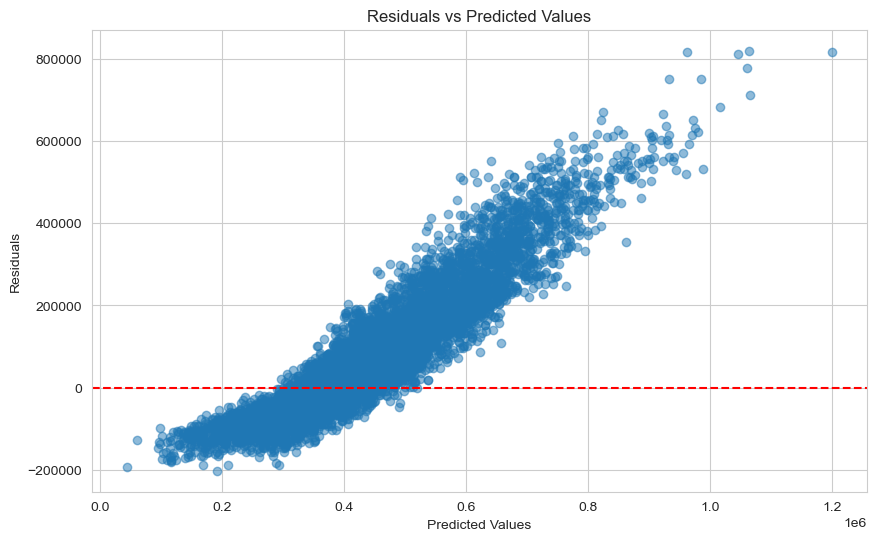

In [122]:
# Residual analysis
residuals = y_val - y_val_pred[0]
# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

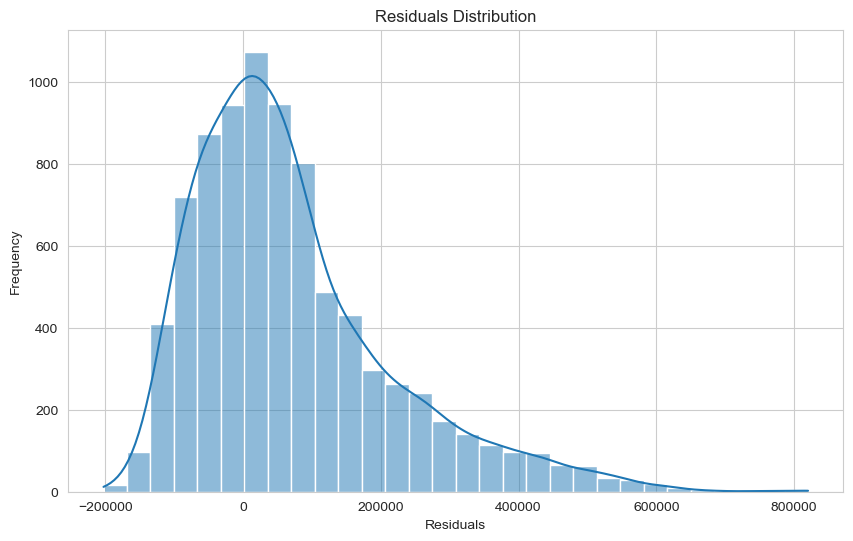

In [123]:
# residual distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

**Residual plot shows that the model did not capture non-linearity in the target. Residual distribution remains skewed. Will try target transformation.**

### Multivariate Linear Regression with Target Transformation

In [124]:
pt = PowerTransformer(method='yeo-johnson')
y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1))

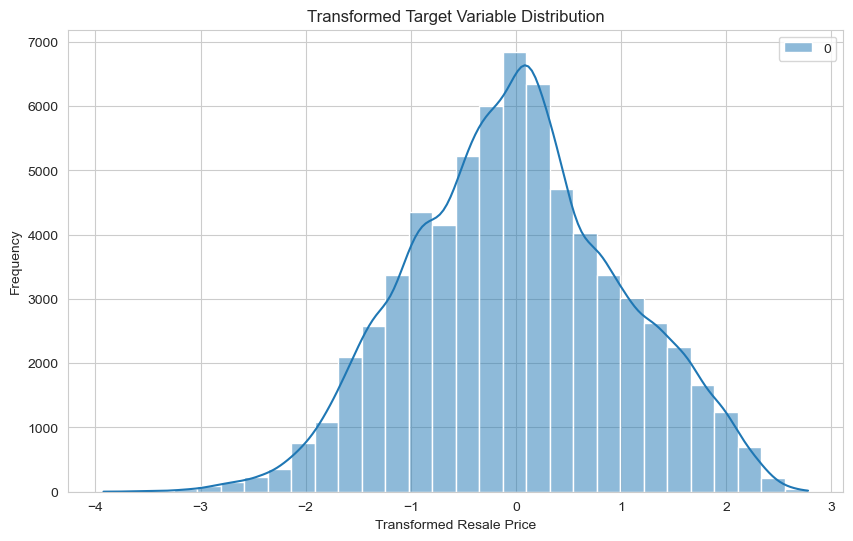

In [125]:
# Plotting the transformed target variable
plt.figure(figsize=(10, 6))
sns.histplot(y_train_transformed, kde=True, bins=30)
plt.title('Transformed Target Variable Distribution')
plt.xlabel('Transformed Resale Price')
plt.ylabel('Frequency')
plt.show()

In [126]:
# Model fitting
lr_pipeline.fit(X_train, y_train_transformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('polynomial_features',
                                                                   PolynomialFeatures(degree=1)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm',
                                                   'remaining_lease_by_months',
                                                   'transac_year']),
                                                 ('nom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['transac_month', 'town_name',
                                                   'flatm_name', 'flat_type']),
                                                 ('ord', 'passthrough', []),
                                                 ('pass', 'passthrough',
                                                  ['storey_range'])])),
                ('regressor', LinearRegression())])

In [127]:
# Prediction on validation set
y_val_pred_transformed = lr_pipeline.predict(X_val)
#print(type(y_val_pred_transformed))
#print(y_val_pred_transformed.shape)
y_val_pred = pt.inverse_transform(y_val_pred_transformed.reshape(-1, 1))  # type: ignore # Inverse transform to get original scale

In [128]:
# Calculate regression metrics for validation set
lr_val_mae_transformed = mean_absolute_error(y_val, y_val_pred)
lr_val_mse_transformed = mean_squared_error(y_val, y_val_pred)
lr_val_rmse_transformed = root_mean_squared_error(y_val, y_val_pred)  
lr_val_r2_transformed = r2_score(y_val, y_val_pred)


# Display the metrics
print(f"Validation MAE (Transformed): {lr_val_mae_transformed}")
print(f"Validation MSE (Transformed): {lr_val_mse_transformed}")
print(f"Validation RMSE (Transformed): {lr_val_rmse_transformed}")
print(f"Validation R2 (Transformed): {lr_val_r2_transformed}")

Validation MAE (Transformed): 38388.50539377241
Validation MSE (Transformed): 3879989539.154485
Validation RMSE (Transformed): 62289.562040156336
Validation R2 (Transformed): 0.8186425441030227


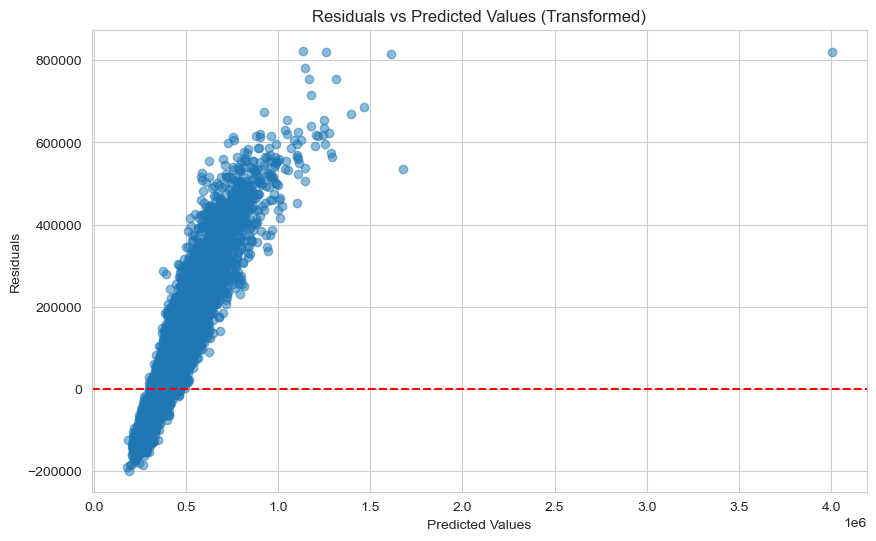

In [129]:
# Residual analysis
residuals = y_val - y_val_pred[0]

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values (Transformed)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

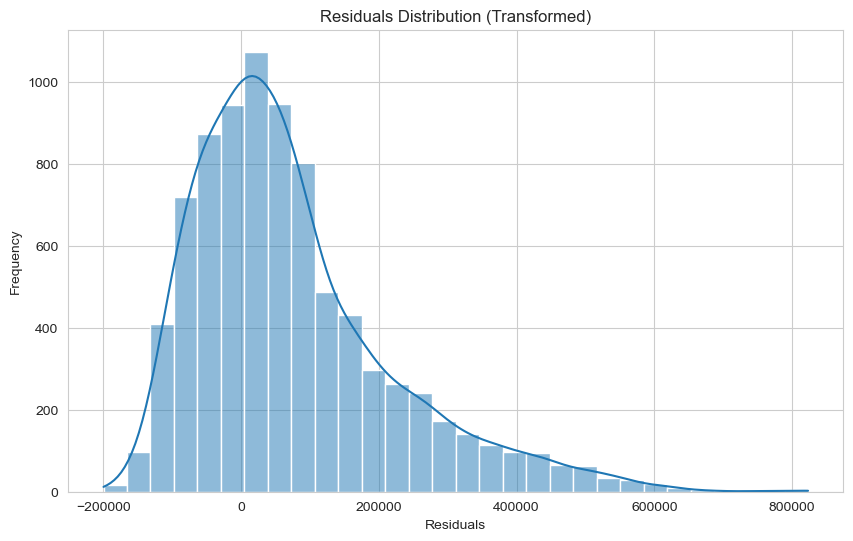

In [130]:
# Residual distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution (Transformed)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

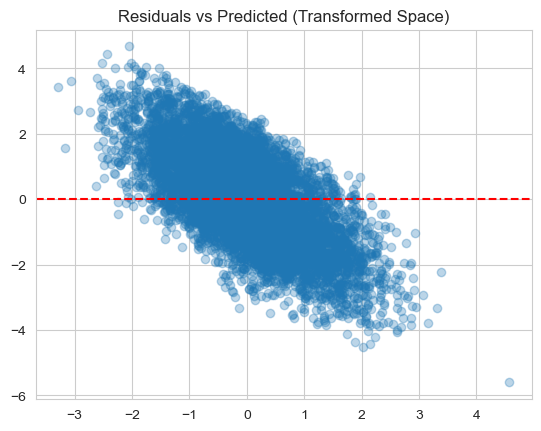

In [131]:
# residual plot in transform space
y_pred_t = lr_pipeline.predict(X_val)          
if isinstance(y_pred_t, tuple):
	y_pred_t_flat = y_pred_t[0].flatten()
else:
	y_pred_t_flat = y_pred_t.flatten()
resid_t = y_train_transformed.flatten()[:len(y_pred_t_flat)] - y_pred_t_flat
plt.scatter(y_pred_t_flat, resid_t, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted (Transformed Space)")
plt.show()


**Comparing the residual plot after target transformation, we can see that linear regression could not catch non-linearity.**

In [132]:
# Display the metrics
print(f"Validation MAE: {lr_val_mae}")
print(f"Validation MSE: {lr_val_mse}")
print(f"Validation RMSE: {lr_val_rmse}")
print(f"Validation R2: {lr_val_r2}")

# Display the metrics
print(f"Validation MAE (Transformed): {lr_val_mae_transformed}")
print(f"Validation MSE (Transformed): {lr_val_mse_transformed}")
print(f"Validation RMSE (Transformed): {lr_val_rmse_transformed}")
print(f"Validation R2 (Transformed): {lr_val_r2_transformed}")

Validation MAE: 42425.72778324604
Validation MSE: 3028225096.661848
Validation RMSE: 55029.311250113315
Validation R2: 0.858455494822378
Validation MAE (Transformed): 38388.50539377241
Validation MSE (Transformed): 3879989539.154485
Validation RMSE (Transformed): 62289.562040156336
Validation R2 (Transformed): 0.8186425441030227


The transformation likely helped normalize the error distribution and reduce the impact of large errors (outliers) in the transformed space. This makes the model more accurate on average, leading to a better Mean Absolute Error.

RMSE got worst and there is a slight dip in R-squared due to the inverse transformation. While the model might be performing well in the transformed scale, any prediction errors, particularly those on the higher end of the original data, get magnified when inverse transformed back to the original scale. Since RMSE heavily penalizes these larger errors (by squaring them), it increases. This overall increase in magnified errors also leads to a slight decrease in R-squared, as the model explains less of the variance in the original scale.

Essentially, the transformation optimized for model performance in a normalized space, but the re-scaling back to the original units amplified certain errors, negatively impacting RMSE and R-squared.

**Transformed target did decrease MAE, which is our business objective, residual plot shows that the model failed to capture non-linearity. We will test with Polynomial regression, Ridge and Lasso regression. Will also try Huber Regression and Quantile Regression.**

### Polynomial Regression with/without Transformation

In [133]:
degree = 6  # Degree of polynomial features, can be adjusted
# Create a numerical transformer pipeline
numerical_transformer = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(degree=degree)),  # Placeholder for polynomial features
    ('scaler', StandardScaler())
])

In [134]:
# Setting preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('nom', nominal_transformer, nominal_features),
        ('ord', 'passthrough', ordinal_features),
        ('pass', 'passthrough', passthrough_features) 
    ],
    remainder='passthrough',
    n_jobs=-1
    )

In [135]:
# Setting up regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

#### Polynomial Regression (No Transformation)

In [136]:
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('polynomial_features',
                                                                   PolynomialFeatures(degree=6)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor_area_sqm',
                                                   'remaining_lease_by_months',
                                                   'transac_year']),
                                                 ('nom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['transac_month', 'town_name',
                                                   'flatm_name', 'flat_type']),
                                                 ('ord', 'passthrough', []),
                                                 ('pass', 'passthrough',
                                                  ['storey_range'])])),
                ('regressor', LinearRegression())])

In [137]:
y_val_pred = lr_pipeline.predict(X_val)

In [138]:
# Calculate regression metrics for validation set
poly_val_mae = mean_absolute_error(y_val, y_val_pred)
poly_val_mse = mean_squared_error(y_val, y_val_pred)
poly_val_rmse = root_mean_squared_error(y_val, y_val_pred)  
poly_val_r2 = r2_score(y_val, y_val_pred)

# Display the metrics
print(f"Validation MAE: {poly_val_mae}")
print(f"Validation MSE: {poly_val_mse}")
print(f"Validation RMSE: {poly_val_rmse}")
print(f"Validation R2: {poly_val_r2}")

Validation MAE: 39953.6265195535
Validation MSE: 2764310647.9138036
Validation RMSE: 52576.71203026872
Validation R2: 0.8707913149364263


#### Polynomial Regression (Transformed Target Regressor)

In [139]:
TransformedTargetRegressor_model = TransformedTargetRegressor(
    regressor    = lr_pipeline,
    transformer  = PowerTransformer(method='yeo-johnson')
)
TransformedTargetRegressor_model.fit(X_train, y_train)
y_val_pred = TransformedTargetRegressor_model.predict(X_val)

In [140]:
# Calculate regression metrics for validation set
poly_val_mae_transformed = mean_absolute_error(y_val, y_val_pred)
poly_val_mse_transformed = mean_squared_error(y_val, y_val_pred)
poly_val_rmse_transformed = root_mean_squared_error(y_val, y_val_pred)  
poly_val_r2_transformed = r2_score(y_val, y_val_pred)

# Display the metrics
print(f"Polynomial Regression Validation MAE with {degree} polynomial degree: {poly_val_mae}")
print(f"Polynomial Regression Validation MSE with {degree} polynomial degree: {poly_val_mse}")
print(f"Polynomial Regression Validation RMSE with {degree} polynomial degree: {poly_val_rmse}")
print(f"Polynomial Regression Validation R2 with {degree} polynomial degree: {poly_val_r2}")

# Display the metrics
print(f"Polynomial Regression Validation MAE (Transformed)  with {degree} polynomial degree: {poly_val_mae_transformed}")
print(f"Polynomial Regression Validation MSE (Transformed)  with {degree} polynomial degree: {poly_val_mse_transformed}")
print(f"Polynomial Regression Validation RMSE (Transformed)  with {degree} polynomial degree: {poly_val_rmse_transformed}")
print(f"Polynomial Regression Validation R2 (Transformed)  with {degree} polynomial degree: {poly_val_r2_transformed}")



Polynomial Regression Validation MAE with 6 polynomial degree: 39953.6265195535
Polynomial Regression Validation MSE with 6 polynomial degree: 2764310647.9138036
Polynomial Regression Validation RMSE with 6 polynomial degree: 52576.71203026872
Polynomial Regression Validation R2 with 6 polynomial degree: 0.8707913149364263
Polynomial Regression Validation MAE (Transformed)  with 6 polynomial degree: 35358.98599110574
Polynomial Regression Validation MSE (Transformed)  with 6 polynomial degree: 2506061798.5277677
Polynomial Regression Validation RMSE (Transformed)  with 6 polynomial degree: 50060.58128435753
Polynomial Regression Validation R2 (Transformed)  with 6 polynomial degree: 0.8828623150874162


**The results shows that target transformation in polynomial regression did improve the performance slightly.** 

### Ridge Regression

In [141]:
# Setting pipeline for Ridge Regression 
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(random_state=42))
])


ridge_pipeline.fit(X_train, y_train)
y_val_pred_ridge = ridge_pipeline.predict(X_val)

In [142]:
# Calculate regression metrics for validation set with Ridge Regression
val_mae_ridge = mean_absolute_error(y_val, y_val_pred_ridge)
val_mse_ridge = mean_squared_error(y_val, y_val_pred_ridge)
val_rmse_ridge = root_mean_squared_error(y_val, y_val_pred_ridge)  
val_r2_ridge = r2_score(y_val, y_val_pred_ridge)

# Print the metrics for Ridge Regression
print("Ridge Regression Metrics:")
print(f"Ridge Regression polynomial degree:{degree} Validation MAE: {val_mae_ridge}")
print(f"Ridge Regression polynomial degree:{degree} MSE: {val_mse_ridge}")
print(f"Ridge Regression polynomial degree:{degree} RMSE: {val_rmse_ridge}")
print(f"Ridge Regression polynomial degree:{degree} R²: {val_r2_ridge}")

Ridge Regression Metrics:
Ridge Regression polynomial degree:6 Validation MAE: 40429.45287554176
Ridge Regression polynomial degree:6 MSE: 2824061885.484637
Ridge Regression polynomial degree:6 RMSE: 53141.90329189045
Ridge Regression polynomial degree:6 R²: 0.8679984382229227


In [143]:
# Target Transformation for Ridge 
TransformedTargetRegressor_model = TransformedTargetRegressor(
    regressor    = ridge_pipeline,
    transformer  = PowerTransformer(method='yeo-johnson')
)
TransformedTargetRegressor_model.fit(X_train, y_train)
y_val_pred_ridge_transformed = TransformedTargetRegressor_model.predict(X_val)

In [144]:

# Calculate regression metrics for validation set with Ridge Regression
val_mae_ridge_transformed = mean_absolute_error(y_val, y_val_pred_ridge_transformed)
val_mse_ridge_transformed = mean_squared_error(y_val, y_val_pred_ridge_transformed)
val_rmse_ridge_transformed = root_mean_squared_error(y_val, y_val_pred_ridge_transformed)  
val_r2_ridge_transformed = r2_score(y_val, y_val_pred_ridge_transformed)

# Print the metrics for Ridge Regression
print("Ridge Regression Metrics:")
print(f"Ridge Regression polynomial degree:{degree} Target Transformation Validation MAE: {val_mae_ridge_transformed}")
print(f"Ridge Regression polynomial degree:{degree} Target Transformation MSE: {val_mse_ridge_transformed}")
print(f"Ridge Regression polynomial degree:{degree} Target Transformation RMSE: {val_rmse_ridge_transformed}")
print(f"Ridge Regression polynomial degree:{degree} Target Transformation R²: {val_r2_ridge_transformed}")

Ridge Regression Metrics:
Ridge Regression polynomial degree:6 Target Transformation Validation MAE: 35861.99305044179
Ridge Regression polynomial degree:6 Target Transformation MSE: 2627508403.2043147
Ridge Regression polynomial degree:6 Target Transformation RMSE: 51259.227493245686
Ridge Regression polynomial degree:6 Target Transformation R²: 0.8771856896663425


### Lasso Regression

In [145]:
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')

# Fit Lasso Regression with default alpha
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha = 0.001, max_iter=3000, random_state=42))
])

TransformedTargetRegressor_model = TransformedTargetRegressor(
    regressor    = lasso_pipeline,
    transformer  = PowerTransformer(method='yeo-johnson')
)
TransformedTargetRegressor_model.fit(X_train, y_train)
y_val_pred_lasso = TransformedTargetRegressor_model.predict(X_val)

# Calculate regression metrics for validation set with Lasso Regression
val_mae_lasso_transformed = mean_absolute_error(y_val, y_val_pred_lasso)
val_mse_lasso_transformed = mean_squared_error(y_val, y_val_pred_lasso)
val_rmse_lasso_transformed = root_mean_squared_error(y_val, y_val_pred_lasso)  # RMSE is the square root of MSE
val_r2_lasso_transformed = r2_score(y_val, y_val_pred_lasso)

# Display the metrics for Lasso Regression
print("Lasso Regression Metrics:")
print(f"Lasso Transformed Validation MAE: {val_mae_lasso_transformed}")
print(f"Lasso Transformed Validation MSE: {val_mse_lasso_transformed}")
print(f"Lasso Transformed Validation RMSE: {val_rmse_lasso_transformed}")
print(f"Lasso Transformed Validation R²: {val_r2_lasso_transformed}")

Lasso Regression Metrics:
Lasso Transformed Validation MAE: 37712.49695282476
Lasso Transformed Validation MSE: 2919680564.0250497
Lasso Transformed Validation RMSE: 54034.068549620155
Lasso Transformed Validation R²: 0.8635290549678072


/opt/miniconda3/envs/hdbenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.352e+02, tolerance: 6.757e+00
  model = cd_fast.enet_coordinate_descent(


In [146]:
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')

# Fit Lasso Regression with default alpha
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(max_iter=2000, random_state=42))
])

lasso_pipeline.fit(X_train, y_train)
y_val_pred_lasso = lasso_pipeline.predict(X_val)

# Calculate regression metrics for validation set with Lasso Regression
val_mae_lasso = mean_absolute_error(y_val, y_val_pred_lasso)
val_mse_lasso = mean_squared_error(y_val, y_val_pred_lasso)
val_rmse_lasso = root_mean_squared_error(y_val, y_val_pred_lasso)  # RMSE is the square root of MSE
val_r2_lasso = r2_score(y_val, y_val_pred_lasso)

# Display the metrics for Lasso Regression
print("Lasso Regression Metrics:")
print(f"Lasso Validation MAE: {val_mae_lasso}")
print(f"Lasso Validation MSE: {val_mse_lasso}")
print(f"Lasso Validation RMSE: {val_rmse_lasso}")
print(f"Lasso Validation R²: {val_r2_lasso}")

Lasso Regression Metrics:
Lasso Validation MAE: 40619.34630255738
Lasso Validation MSE: 2847374501.6817403
Lasso Validation RMSE: 53360.795549558105
Lasso Validation R²: 0.8669087660160407


/opt/miniconda3/envs/hdbenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.357e+13, tolerance: 1.457e+11
  model = cd_fast.enet_coordinate_descent(


### Huber Regression

This is an experiment on Huber Regression as no transformation is required.

In [147]:
degree = 6  # Degree of polynomial features, can be adjusted
# Create a numerical transformer pipeline
numerical_transformer = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(degree=degree)),  # Placeholder for polynomial features
    ('scaler', StandardScaler())
])

In [148]:
# Setting preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('nom', nominal_transformer, nominal_features),
        ('ord', 'passthrough', ordinal_features),
        ('pass', 'passthrough', passthrough_features) 
    ],
    remainder='passthrough',
    n_jobs=-1
    )

In [149]:
# Setting pipeline for Huber Regression 
huber_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', HuberRegressor(epsilon=1.1, max_iter=3000, alpha=0.0)) # usually 1.35 epsilon
])


huber_pipeline.fit(X_train, y_train)
y_val_pred_huber = huber_pipeline.predict(X_val)

/opt/miniconda3/envs/hdbenv/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [150]:
# Calculate regression metrics for validation set with Huber Regression
val_mae_huber = mean_absolute_error(y_val, y_val_pred_huber)
val_mse_huber = mean_squared_error(y_val, y_val_pred_huber)
val_rmse_huber = root_mean_squared_error(y_val, y_val_pred_huber)  
val_r2_huber = r2_score(y_val, y_val_pred_huber)

# Display the metrics for Huber Regression
print("Huber Regression Metrics:")
print(f"Huber Validation MAE: {val_mae_huber}")
print(f"Huber Validation MSE: {val_mse_huber}")
print(f"Huber Validation RMSE: {val_rmse_huber}")
print(f"Huber Validation R²: {val_r2_huber}")

Huber Regression Metrics:
Huber Validation MAE: 39611.177702834786
Huber Validation MSE: 2937349006.293199
Huber Validation RMSE: 54197.31548972882
Huber Validation R²: 0.8627032012619973


### Quantile Regression

This is an experiment on Quantile regression to check the performance against traditional linear models.

In [151]:
# Setting pipeline for Quantile Regression (mid quantile)
quantile_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', QuantileRegressor(quantile=0.5, alpha=1e-3, solver='highs-ds'))
])

quantile_pipeline.fit(X_train, y_train)
y_val_pred_quant_5 = quantile_pipeline.predict(X_val)

In [152]:
# Calculate regression metrics for validation set with Quantile Regression
val_mae_quant_5 = mean_absolute_error(y_val, y_val_pred_quant_5)
val_mse_quant_5 = mean_squared_error(y_val, y_val_pred_quant_5)
val_rmse_quant_5 = root_mean_squared_error(y_val, y_val_pred_quant_5)  
val_r2_quant_5 = r2_score(y_val, y_val_pred_quant_5)

# Display the metrics for Quantile Regression
print("Quantile Regression Metrics:")
print(f"Quantile Validation MAE: {val_mae_quant_5}")
print(f"Quantile Validation MSE: {val_mse_quant_5}")
print(f"Quantile Validation RMSE: {val_rmse_quant_5}")
print(f"Quantile Validation R²: {val_r2_quant_5}")

Quantile Regression Metrics:
Quantile Validation MAE: 41504.56761190359
Quantile Validation MSE: 3356190424.7089915
Quantile Validation RMSE: 57932.63695628736
Quantile Validation R²: 0.8431258252661016


In [ ]:
# Setting pipeline for Quantile Regression (top end quantile)
quantile_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', QuantileRegressor(quantile=0.9, alpha=1e-3, solver='highs-ds'))
])

quantile_pipeline.fit(X_train, y_train)
y_val_pred_quant_9 = quantile_pipeline.predict(X_val)

In [ ]:
# Calculate regression metrics for validation set with Quantile Regression
val_mae_quant_9 = mean_absolute_error(y_val, y_val_pred_quant_9)
val_mse_quant_9 = mean_squared_error(y_val, y_val_pred_quant_9)
val_rmse_quant_9 = root_mean_squared_error(y_val, y_val_pred_quant_9)  
val_r2_quant_9 = r2_score(y_val, y_val_pred_quant_9)

# Display the metrics for Quantile Regression
print("Quantile Regression Metrics:")
print(f"Quantile Validation MAE: {val_mae_quant_9}")
print(f"Quantile Validation MSE: {val_mse_quant_9}")
print(f"Quantile Validation RMSE: {val_rmse_quant_9}")
print(f"Quantile Validation R²: {val_r2_quant_9}")

**Quantile and Huber Regression did not outperform traditional linear model. We will compare metric on Polynomial, Ridge and Lasso Regression.**

#### Linear Model Metric Analysis

In [ ]:
# Add metrics to dictionary for each model with category
metrics_poly = {
    "Category": "Original",
    "Model": "Polynomial Regression",
    "MAE":  poly_val_mae,
    "RMSE": poly_val_rmse,
    "R2":   poly_val_r2,
}

metrics_poly_transformed = {
    "Category": "Target Transformed",
    "Model": "Polynomial Regression",
    "MAE":  poly_val_mae_transformed,
    "RMSE": poly_val_rmse_transformed,
    "R2":   poly_val_r2_transformed,
}

metrics_ridge = {
    "Category": "Original",
    "Model": "Ridge Regression",
    "MAE":  val_mae_ridge,
    "RMSE": val_rmse_ridge,
    "R2":   val_r2_ridge,
}

metrics_ridge_transformed = {
    "Category": "Target Transformed",
    "Model": "Ridge Regression",
    "MAE":  val_mae_ridge_transformed,
    "RMSE": val_rmse_ridge_transformed,
    "R2":   val_r2_ridge_transformed,
}

metrics_lasso = {
    "Category": "Original",
    "Model": "Lasso Regression",
    "MAE":  val_mae_lasso,
    "RMSE": val_rmse_lasso,
    "R2":   val_r2_lasso,
}

metrics_lasso_transformed = {
    "Category": "Target Transformed",
    "Model": "Lasso Regression",
    "MAE":  val_mae_lasso_transformed,
    "RMSE": val_rmse_lasso_transformed,
    "R2":   val_r2_lasso_transformed,
}

# Append all metrics dictionaries to the results list
all_results = [
    metrics_poly,
    metrics_ridge,
    metrics_lasso,
    metrics_poly_transformed,
    metrics_ridge_transformed,
    metrics_lasso_transformed
]

# Create DataFrame with multi-level index
results_df = (
    pd.DataFrame(all_results)
      .set_index(["Category", "Model"])
      .round(4)
)

print("="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(results_df.to_string())

# Alternative: Create separate sections with cleaner display
print("\n" + "="*80)
print("MODEL PERFORMANCE - SEPARATED BY TRANSFORMATION")
print("="*80)

# Group by category and display each section
for category in results_df.index.get_level_values('Category').unique():
    print(f"\n{category.upper()} MODELS:")
    print("-" * 80)
    section_df = results_df.loc[category].round(4)
    print(section_df.to_string())

**Regularization will reduce validation performance, but the difference is not that huge if we are looking at R2 or MAE. We need further fine tuning and apply the model to the test set before we can decide who model to use. However, we will try Decision Tree model since our target are non-linear.** 

### Decision Tree Based Baseline Model

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('nom', nominal_transformer, nominal_features),
        ('ord', 'passthrough', ordinal_features),
        ('pass', 'passthrough', passthrough_features) 
    ],
    remainder='passthrough',
    n_jobs=-1
    )

In [ ]:
# Decision Tree Regressor

dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])
dt_pipeline.fit(X_train, y_train)   

In [ ]:
# Predict on the validation set with Decision Tree Regressor
y_val_pred_dt = dt_pipeline.predict(X_val)  
# Calculate regression metrics for validation set with Decision Tree Regressor
val_mae_dt = mean_absolute_error(y_val, y_val_pred_dt)
val_mse_dt = mean_squared_error(y_val, y_val_pred_dt)
val_rmse_dt = root_mean_squared_error(y_val, y_val_pred_dt)
val_r2_dt = r2_score(y_val, y_val_pred_dt)  

# Display the metrics for Decision Tree Regressor
print("Decision Tree Regressor Metrics:")
print(f"Decision Tree Validation MAE: {val_mae_dt}")
print(f"Decision Tree Validation MSE: {val_mse_dt}")
print(f"Decision Tree Validation RMSE: {val_rmse_dt}")
print(f"Decision Tree Validation R²: {val_r2_dt}")

In [ ]:
# Display the feature importance
dt_feature_importances = dt_pipeline.named_steps['regressor'].feature_importances_
dt_feature_names = preprocessor.get_feature_names_out()
dt_feature_importances_df = pd.DataFrame({'Feature': dt_feature_names, 'Importance': dt_feature_importances})
dt_feature_importances_df = dt_feature_importances_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print("\nDecision Tree Feature Importances (Top 20):")
print(dt_feature_importances_df[:20])  # Display top 20 features

**Using basic decision tree model without any parameter tuning, our error reduced and performance improve is much better than Linear Regression with transformed target. We have a MAE of $30K and R-squared of 90%. We believe that any parameter fine tuning on linear model will not be able to outperform the decision tree base line model. We will stop using linear models and adopt tree-based model as our recommended model.**
 

### Random Forest

In [ ]:
# Random Forest Regressor
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])
rf_pipeline.fit(X_train, y_train)

In [ ]:
# predict on the validation set with Random Forest Regressor
y_val_pred_rf = rf_pipeline.predict(X_val)

# Calculate regression metrics for validation set with Random Forest Regressor
val_mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
val_mse_rf = mean_squared_error(y_val, y_val_pred_rf)
val_rmse_rf = root_mean_squared_error(y_val, y_val_pred_rf)
val_r2_rf = r2_score(y_val, y_val_pred_rf)

# Display the metrics for Random Forest Regressor
print("Random Forest Regressor Metrics:")
print(f"Random Forest Validation MAE: {val_mae_rf}")
print(f"Random Forest Validation MSE: {val_mse_rf}")
print(f"Random Forest Validation RMSE: {val_rmse_rf}")
print(f"Random Forest Validation R²: {val_r2_rf}")

In [ ]:
# Display the feature importances for Random Forest
rf_feature_importances = rf_pipeline.named_steps['regressor'].feature_importances_
rf_feature_names = preprocessor.get_feature_names_out()
rf_feature_importances_df = pd.DataFrame({'Feature': rf_feature_names, 'Importance': rf_feature_importances})
rf_feature_importances_df = rf_feature_importances_df.sort_values(by='Importance', ascending=False)
# Print the feature importances for Random Forest
print("\nRandom Forest Feature Importances (Top 20):")
print(rf_feature_importances_df[:20])  # Display top 20 features

### XGBoost

In [ ]:
# XGBoost Regressor
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0))
])
xgb_pipeline.fit(X_train, y_train)  

In [ ]:
# predict on the validation set with XGBoost Regressor
y_val_pred_xgb = xgb_pipeline.predict(X_val)

# Calculate regression metrics for validation set with XGBoost Regressor
val_mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
val_mse_xgb = mean_squared_error(y_val, y_val_pred_xgb)
val_rmse_xgb = root_mean_squared_error(y_val, y_val_pred_xgb)
val_r2_xgb = r2_score(y_val, y_val_pred_xgb)

# Display the metrics for XGBoost Regressor
print("XGBoost Regressor Metrics:")
print(f"XGBoost Validation MAE: {val_mae_xgb}")
print(f"XGBoost Validation MSE: {val_mse_xgb}")
print(f"XGBoost Validation RMSE: {val_rmse_xgb}")
print(f"XGBoost Validation R²: {val_r2_xgb}")

In [ ]:
# Display the feature importances of XGBoost
xgb_feature_importances = xgb_pipeline.named_steps['regressor'].feature_importances_
xgb_feature_names = preprocessor.get_feature_names_out()
xgb_feature_importances_df = pd.DataFrame({'Feature': xgb_feature_names, 'Importance': xgb_feature_importances})
xgb_feature_importances_df = xgb_feature_importances_df.sort_values(by='Importance', ascending=False)

# Print the feature importances of XGBoost
print("\nXGBoost Feature Importances (Top 20):")
print(xgb_feature_importances_df[:20])  # Display top 20 features   

### LightGBM

In [ ]:
# LightGBM Regressor
lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbosity=-1))
])
lgb_pipeline.fit(X_train, y_train)

In [ ]:
# predict on the validation set with LightGBM Regressor
y_val_pred_lgb = lgb_pipeline.predict(X_val)

# Calculate regression metrics for validation set with LightGBM Regressor
val_mae_lgb = mean_absolute_error(y_val, y_val_pred_lgb)
val_mse_lgb = mean_squared_error(y_val, y_val_pred_lgb)
val_rmse_lgb = root_mean_squared_error(y_val, y_val_pred_lgb)
val_r2_lgb = r2_score(y_val, y_val_pred_lgb)

# Display the metrics for LightGBM Regressor
print("LightGBM Regressor Metrics:")
print(f"LightGBM Validation MAE: {val_mae_lgb}")
print(f"LightGBM Validation MSE: {val_mse_lgb}")
print(f"LightGBM Validation RMSE: {val_rmse_lgb}")
print(f"LightGBM Validation R²: {val_r2_lgb}")

In [ ]:
# Display the feature importances of LightGBM
lgb_feature_importances = lgb_pipeline.named_steps['regressor'].feature_importances_
lgb_feature_names = preprocessor.get_feature_names_out()
lgb_feature_importances_df = pd.DataFrame({'Feature': lgb_feature_names, 'Importance': lgb_feature_importances})
lgb_feature_importances_df = lgb_feature_importances_df.sort_values(by='Importance', ascending=False)
# Print the feature importances of LightGBM
print("\nLightGBM Feature Importances (Top 20):")
print(lgb_feature_importances_df[:20])  # Display top 20 features

In [ ]:
# add ing metrics to dictionary for each model
metrics_dt = {
    "Model": "Decision Tree",
    "MAE":  val_mae_dt,
    "RMSE": val_rmse_dt,
    "R2":   val_r2_dt,
}

metrics_lgb = {
    "Model": "LightGBM",
    "MAE":  val_mae_lgb,
    "RMSE": val_rmse_lgb,
    "R2":   val_r2_lgb,
}

metrics_rf = {
    "Model": "Random Forest",
    "MAE":  val_mae_rf,
    "RMSE": val_rmse_rf,
    "R2":   val_r2_rf,
}

metrics_xgb = {
    "Model": "XGBoost",
    "MAE":  val_mae_xgb,
    "RMSE": val_rmse_xgb,
    "R2":   val_r2_xgb,
}


all_results = [metrics_dt, metrics_rf, metrics_xgb, metrics_lgb]

results_df = (
    pd.DataFrame(all_results)
      .set_index("Model")
      .round(4)          # nice, tidy formatting
)

In [ ]:
display(results_df)

In [ ]:
# Saved for final sanity check
dt_default_model = dt_pipeline
rf_default_model = rf_pipeline

**Without any parameters tuning, Random Forest shows the most promising results, followed by XGBoost and LightGBM. We will use the 3 models for further hyperparameter tuning. Decision tree without tuning will be the base line model for sanity check.** 

## Performance Metrics

In [ ]:
display(results_df)

**MSE is too difficult to interpret and thus we have dropped it from the analysis. We will be using MAE, RMSE and R-squared. We should look at all the different performance metrics MAE, RMSE and R2 because different performance metric present different information. MAE measure the magnitude of errors but it is less sensitive to outliers. RMSE penalized large errors and helps to identify if you have large outliers. R2 tell us how much of the variation in the target are explainable by our model. However, it cannot tell us if the predictions are bias.**

**Our analysis above shows that RMSE and larger than MAE indicating that there are outliers that RMSE amplified. We will not use RMSE as we do not want to penalized the squared error since the outliers are the high end housing market that our property firm would want to served. Our R-squared are consistently high indicating that our tree-based models can explain the variation in the target better. However, the differences between difference R-squared could not help us to explain the metrics further. In conclusion, we would use MAE as our primary metrics as it is also easier to explained to the management of the property firm.**   

## Hyperparameter Tuning

**Grid Search Strategy**

We will use **MAE** as the main metric because it is most easy to be understood by the stakeholder.

We have performed fine tuning with a 3 stage parameters fine tuning starting with **Randomized Search** for stage 1 using the widest search space. Then we will use **Halving Randomized Search** based on the search result of stage 1 and finally, we will use **Optuna Search** to finalized the search parameters.

However, after several hours of fine tuning, our MAE did improved a few hundred dollars. This is not acceptable as the improvement is marginal compared to the resource we have put in. Thus we will be using randomized search  with ranges around the default as sanity check.

For further fine tuning, we will be using optuna with 5 cross validation folder around our searched parameters.

### Random Search CV Parameters Settings

In [ ]:
# Define RansomizedSearchCV parameters with wide search space for Decision Tree Regressor, Random Forest Regressor, XGBoost Regressor, and LightGBM Regressor

rf_param_grid = {
    'regressor__n_estimators':    [100, 200, 300],       
    'regressor__max_depth':       [40, 50, 60],           
    'regressor__min_samples_split': [2, 5, 7, 10],
    'regressor__min_samples_leaf':  [1, 5, 7, 10],
    'regressor__max_features':      ['sqrt', 'log2', 0.5, 1.0]
}   

xgb_param_grid = {
    'regressor__n_estimators': [50, 100, 200],      
    'regressor__max_depth': [3, 5, 7, 9],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
    'regressor__gamma': [0, 0.1, 0.2],
    'regressor__reg_alpha': [0, 0.1, 1],
    'regressor__reg_lambda': [0, 0.1, 1]
}   

lgb_param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [3, 5, 7, 9],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__num_leaves': [31, 63, 127],
    'regressor__min_child_samples': [20, 30, 40],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
    'regressor__reg_alpha': [0, 0.1, 1],
    'regressor__reg_lambda': [0, 0.1, 1]
}


In [ ]:
rf_random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_param_grid,
    scoring='neg_mean_absolute_error',
    n_iter=5,
    cv=3,
    verbose=3,
    random_state=42,
    n_jobs=-1
)
rf_random_search.fit(X_train, y_train)

In [ ]:
# perform randomized search for XGBoost Regressor
xgb_random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=xgb_param_grid,
    n_iter=60,  # Number of iterations for random search
    scoring='neg_mean_absolute_error',   
    cv=3,  # 3-fold cross-validation
    verbose=3,
    random_state=42,
    n_jobs=-1  # Use all available cores
)
xgb_random_search.fit(X_train, y_train) 

In [ ]:
# perform randomized search for LightGBM Regressor
lgb_random_search = RandomizedSearchCV(
    lgb_pipeline,
    param_distributions=lgb_param_grid,
    n_iter=30,  # Number of iterations for random search
    scoring='neg_mean_absolute_error',       
    cv=3,  # 3-fold cross-validation
    verbose=3,
    random_state=42,
    n_jobs=-1  # Use all available cores
)
lgb_random_search.fit(X_train, y_train)

In [ ]:
# Print the best parameters and best score for Random Forest Regressor
print("Best parameters for Random Forest Regressor:", rf_random_search.best_params_)
print("Best score for Random Forest Regressor (negative MSE):", rf_random_search.best_score_)
# Print the best parameters and best score for XGBoost Regressor
print("Best parameters for XGBoost Regressor:", xgb_random_search.best_params_)
print("Best score for XGBoost Regressor (negative MSE):", xgb_random_search.best_score_)
# Print the best parameters and best score for LightGBM Regressor
print("Best parameters for LightGBM Regressor:", lgb_random_search.best_params_)
print("Best score for LightGBM Regressor (negative MSE):", lgb_random_search.best_score_)

**The difference between the best model is not that great. Will perform fine tuning and select the best few for final model evaluation test.**

### Optuna Grid Search CV

In [ ]:
def make_tight_distributions(best_params,
                             int_frac: float = 0.2,
                             float_frac: float = 0.1,
                             min_int_step: int = 1):
    """
    Given a dict of best_params_, return a dict of
    Optuna Distributions that span ±frac around each value.
    """
    tight_dists = {}
    for name, val in best_params.items():
        # only handle numeric params
        if isinstance(val, int):
            # window = max(val * int_frac, min_int_step)
            window = max(int(val * int_frac), min_int_step)
            low  = max(1, val - window)      # avoid zero or negative
            high = val + window
            # choose step = min_int_step or window itself
            step = min_int_step if min_int_step <= window else window
            tight_dists[name] = IntDistribution(low=low, high=high, step=step)

        elif isinstance(val, float):
            window = val * float_frac
            low  = max(0.0, val - window)
            high = min(1.0, val + window)    # assuming [0,1] support for fractions
            tight_dists[name] = FloatDistribution(low=low, high=high)

        else:
            # skip non-numeric (e.g. categorical) or handle separately
            continue

    return tight_dists


#### Random Forest Optuna Search CV

In [ ]:

# 1. grab your previously-found best params:
best_rf_random_search = rf_random_search.best_params_

# 2. build the “around-the-best” distributions:
rf_param_distributions = make_tight_distributions(best_rf_random_search,
                                               int_frac=0.2,     # ±20%
                                               float_frac=0.1,   # ±10%
                                               min_int_step=1)   # at least step=1


In [ ]:
rf_param_distributions

In [ ]:
# 3. Optuna quick search
optuna_search = OptunaSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_distributions,
    cv=5,             
    n_trials=2,      
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=3,
)

# 4. Run the search
optuna_search.fit(X_train, y_train)


In [ ]:
# 5. Inspect results
print("Best MAE  =", optuna_search.best_score_)
print("Best params:")
for k, v in optuna_search.best_params_.items():
    print(f"  • {k} = {v}")

# 6. Your final model
final_rf_model = optuna_search.best_estimator_
final_rf_model_params = optuna_search.best_params_
final_rf_model_scores = optuna_search.best_score_

In [ ]:
val_final_rf_model_pred = final_rf_model.predict(X_val)

# 7. Calculate regression metrics for validation set with Random Forest Regressor
final_val_mae_rf = mean_absolute_error(y_val, val_final_rf_model_pred)
final_val_mse_rf = mean_squared_error(y_val, val_final_rf_model_pred)
final_val_rmse_rf = root_mean_squared_error(y_val, val_final_rf_model_pred)
final_val_r2_rf = r2_score(y_val, val_final_rf_model_pred)

# 8. Display the metrics for Random Forest Regressor
print("Random Forest Regressor Metrics:")
print(f"Random Forest Validation MAE: {final_val_mae_rf}")
print(f"Random Forest Validation MSE: {final_val_mse_rf}")
print(f"Random Forest Validation RMSE: {final_val_rmse_rf}")
print(f"Random Forest Validation R²: {final_val_r2_rf}")

#### XGBoost Optuna Search CV

In [ ]:
# 1. grab your previously-found best params:
best_xgb_random_search_param = xgb_random_search.best_params_

# 2. build the “around-the-best” distributions:
xgb_param_distributions = make_tight_distributions(best_xgb_random_search_param,
                                               int_frac=0.2,     # ±20%
                                               float_frac=0.1,   # ±10%
                                               min_int_step=1)   # at least step=1


In [ ]:
xgb_param_distributions

In [ ]:
# 3. Optuna quick search
optuna_search = OptunaSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_distributions,
    cv=5,             
    n_trials=50,      
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=3,
)

# 4. Run the search
optuna_search.fit(X_train, y_train)

In [ ]:
# 5. Inspect results
print("Best MAE  =", optuna_search.best_score_)
print("Best params:")
for k, v in optuna_search.best_params_.items():
    print(f"  • {k} = {v}")

# 6. Your final model
final_xgb_model = optuna_search.best_estimator_
final_xgb_model_params = optuna_search.best_params_
final_xgb_model_scores = optuna_search.best_score_

In [ ]:
val_final_xgb_model = final_xgb_model.predict(X_val)

# 7. Calculate regression metrics for validation set with Random Forest Regressor
final_val_mae_xgb = mean_absolute_error(y_val, val_final_xgb_model)
final_val_mse_xgb = mean_squared_error(y_val, val_final_xgb_model)
final_val_rmse_xgb = root_mean_squared_error(y_val, val_final_xgb_model)
final_val_r2_xgb = r2_score(y_val, val_final_xgb_model)

# 8. Display the metrics for Random Forest Regressor
print("Random Forest Regressor Metrics:")
print(f"Random Forest Validation MAE: {final_val_mae_xgb}")
print(f"Random Forest Validation MSE: {final_val_mse_xgb}")
print(f"Random Forest Validation RMSE: {final_val_rmse_xgb}")
print(f"Random Forest Validation R²: {final_val_r2_xgb}")

#### Light GBM Optuna Search CV

In [ ]:
# 1. grab your previously-found best params:
best_lgb_random_search_param = lgb_random_search.best_params_

# 2. build the “around-the-best” distributions:
lgb_param_distributions = make_tight_distributions(best_lgb_random_search_param,
                                               int_frac=0.2,     # ±20%
                                               float_frac=0.1,   # ±10%
                                               min_int_step=1)   # at least step=1

In [ ]:
lgb_param_distributions

In [ ]:
# 3. Optuna quick search
optuna_search = OptunaSearchCV(
    estimator=lgb_pipeline,
    param_distributions=lgb_param_distributions,
    cv=5,             
    n_trials=30,      
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=3,
)

# 4. Run the search
optuna_search.fit(X_train, y_train)

In [ ]:
# 5. Inspect results
print("Best MAE  =", optuna_search.best_score_)
print("Best params:")
for k, v in optuna_search.best_params_.items():
    print(f"  • {k} = {v!r}")

# 6. Your final model
final_lgb_model = optuna_search.best_estimator_
final_lgb_model_params = optuna_search.best_params_
final_lgb_model_scores = optuna_search.best_score_

In [ ]:
val_final_lgb_model = final_lgb_model.predict(X_val)

# 7. Calculate regression metrics for validation set with Random Forest Regressor
final_val_mae_lgb = mean_absolute_error(y_val, val_final_lgb_model)
final_val_mse_lgb = mean_squared_error(y_val, val_final_lgb_model)
final_val_rmse_lgb = root_mean_squared_error(y_val, val_final_lgb_model)
final_val_r2_lgb = r2_score(y_val, val_final_lgb_model)

# 8. Display the metrics for Random Forest Regressor
print("Random Forest Regressor Metrics:")
print(f"Random Forest Validation MAE: {final_val_mae_lgb}")
print(f"Random Forest Validation MSE: {final_val_mse_lgb}")
print(f"Random Forest Validation RMSE: {final_val_rmse_lgb}")
print(f"Random Forest Validation R²: {final_val_r2_lgb}")

#### Comparing Fine Tuned Scores

In [ ]:
# Print the best parameters and best score for Random Forest Regressor
print("Best parameters for Random Forest Regressor:", final_rf_model_params)
print("Best score for Random Forest Regressor (negative MSE):", final_rf_model_scores)
# Print the best parameters and best score for XGBoost Regressor
print("Best parameters for XGBoost Regressor:", final_xgb_model_params)
print("Best score for XGBoost Regressor (negative MSE):", final_xgb_model_scores)
# Print the best parameters and best score for LightGBM Regressor
print("Best parameters for LightGBM Regressor:", final_lgb_model_params)
print("Best score for LightGBM Regressor (negative MSE):", final_lgb_model_scores)


### Evaluation of Fine Tuned Models

**First, we apply the default decision tree as baseline for sanity check.**

In [ ]:
# Predict on the validation set with the default Decision Tree Regressor
y_val_pred_dt_default = dt_default_model.predict(X_val)
# Calculate regression metrics for validation set with the default Decision Tree Regressor
val_mae_dt_default = mean_absolute_error(y_val, y_val_pred_dt_default)
val_rmse_dt_default = root_mean_squared_error(y_val, y_val_pred_dt_default)
val_r2_dt_default = r2_score(y_val, y_val_pred_dt_default)

# Display the metrics for the default Decision Tree Regressor
print("Default Decision Tree Regressor Metrics:")
print(f"Default Decision Tree Validation MAE: {val_mae_dt_default}")
print(f"Default Decision Tree Validation RMSE: {val_rmse_dt_default}")
print(f"Default Decision Tree Validation R²: {val_r2_dt_default}")

**Next, we try Random Forest with default settings as it has a good score before fine tuning.**

In [ ]:
# Predict on the test set with the default Random Forest Regressor
y_val_pred_rf_default = rf_default_model.predict(X_val)
# Calculate regression metrics for test set with the default Random Forest Regressor
val_mae_rf_default = mean_absolute_error(y_val, y_val_pred_rf_default)
val_rmse_rf_default = root_mean_squared_error(y_val, y_val_pred_rf_default)
val_r2_rf_default = r2_score(y_val, y_val_pred_rf_default)

# Display the metrics for the default Random Forest Regressor
print("Default Random Forest Regressor Metrics:")
print(f"Default Random Forest Validation MAE: {val_mae_rf_default}")
print(f"Default Random Forest Validation RMSE: {val_rmse_rf_default}")
print(f"Default Random Forest Validation R²: {val_r2_rf_default}")

In [ ]:
# predict on the validation set with the best Random Forest Regressor
y_val_pred_rf_best = final_rf_model.predict(X_val)
# Calculate regression metrics for validation set with the best Random Forest Regressor
val_mae_rf_best = mean_absolute_error(y_val, y_val_pred_rf_best)
val_rmse_rf_best = root_mean_squared_error(y_val, y_val_pred_rf_best)
val_r2_rf_best = r2_score(y_val, y_val_pred_rf_best)    

# Display the metrics for the best Random Forest Regressor
print("Best Random Forest Regressor Metrics:")
print(f"Best Random Forest Validation MAE: {val_mae_rf_best}")
print(f"Best Random Forest Validation RMSE: {val_rmse_rf_best}")
print(f"Best Random Forest Validation R²: {val_r2_rf_best}")

In [ ]:
# predict on the validation set with the best xgboost Regressor
y_val_pred_xgb_best = final_xgb_model.predict(X_val)
# Calculate regression metrics for validation set with the best XGBoost Regressor
val_mae_xgb_best = mean_absolute_error(y_val, y_val_pred_xgb_best)
val_rmse_xgb_best = root_mean_squared_error(y_val, y_val_pred_xgb_best)
val_r2_xgb_best = r2_score(y_val, y_val_pred_xgb_best)  
# Display the metrics for the best XGBoost Regressor
print("Best XGBoost Regressor Metrics:")
print(f"Best XGBoost Validation MAE: {val_mae_xgb_best}")       
print(f"Best XGBoost Validation RMSE: {val_rmse_xgb_best}")
print(f"Best XGBoost Validation R²: {val_r2_xgb_best}") 


In [ ]:
# predict on the validation set with the best lightgbm Regressor
y_val_pred_lgb_best = final_lgb_model.predict(X_val)
# Calculate regression metrics for validation set with the best LightGBM Regressor
val_mae_lgb_best = mean_absolute_error(y_val, y_val_pred_lgb_best)
val_rmse_lgb_best = root_mean_squared_error(y_val, y_val_pred_lgb_best)
val_r2_lgb_best = r2_score(y_val, y_val_pred_lgb_best)
# Display the metrics for the best LightGBM Regressor
print("Best LightGBM Regressor Metrics:")
print(f"Best LightGBM Validation MAE: {val_mae_lgb_best}")
print(f"Best LightGBM Validation RMSE: {val_rmse_lgb_best}")
print(f"Best LightGBM Validation R²: {val_r2_lgb_best}")    


In [ ]:
# add ing metrics to dictionary for each model
metrics_rf_default = {
    "Model": "Random Forest (def)",
    "MAE":  val_mae_rf_default,
    "RMSE": val_rmse_rf_default,
    "R2":   val_r2_rf_default,
}

metrics_rf = {
    "Model": "Random Forest",
    "MAE":  val_mae_rf_best,
    "RMSE": val_rmse_rf_best,
    "R2":   val_r2_rf_best,
}

metrics_xgb = {
    "Model": "XGBoost",
    "MAE":  val_mae_xgb_best,
    "RMSE": val_rmse_xgb_best,
    "R2":   val_r2_xgb_best,
}

metrics_lgb = {
    "Model": "LightGBM",
    "MAE":  val_mae_lgb_best,
    "RMSE": val_rmse_lgb_best,
    "R2":   val_r2_lgb_best,
}

all_results = [metrics_rf_default, metrics_rf, metrics_xgb, metrics_lgb]

results_df = (
    pd.DataFrame(all_results)
      .set_index("Model")
      .round(4)          # nice, tidy formatting
)

In [ ]:
display(results_df)

**Our best model is XGBoost with MAE of $23,338 margin or errors.**

**All MAE are very close. In our experience, model with the best validation score may not do well in the test. Therefore, we will apply all the 4 models into the test set. We will deploy model with the best score.**



## Final Model Evaluation

In [ ]:
# Predict on the test set with the default Random Forest Regressor
y_test_pred_rf_default = rf_default_model.predict(X_test)
# Calculate regression metrics for test set with the default Random Forest Regressor
test_mae_rf_default = mean_absolute_error(y_test, y_test_pred_rf_default)
test_rmse_rf_default = root_mean_squared_error(y_test, y_test_pred_rf_default)
test_r2_rf_default = r2_score(y_test, y_test_pred_rf_default)

# Display the metrics for the default Random Forest Regressor
print("Default Random Forest Regressor Metrics:")
print(f"Default Random Forest Test MAE: {test_mae_rf_default}")
print(f"Default Random Forest Test RMSE: {test_rmse_rf_default}")
print(f"Default Random Forest Test R²: {test_r2_rf_default}")

In [ ]:
# Predict on the test set with the best Random Forest Regressor
y_test_pred_rf_best = final_rf_model.predict(X_test)
# Calculate regression metrics for test set with the best Random Forest Regressor
test_mae_rf_best = mean_absolute_error(y_test, y_test_pred_rf_best)
test_rmse_rf_best = root_mean_squared_error(y_test, y_test_pred_rf_best)
test_r2_rf_best = r2_score(y_test, y_test_pred_rf_best)

# Display the metrics for the best Random Forest Regressor
print("Best Random Forest Regressor Metrics:")
print(f"Best Random Forest Test MAE: {test_mae_rf_best}")
print(f"Best Random Forest Test RMSE: {test_rmse_rf_best}")
print(f"Best Random Forest Test R²: {test_r2_rf_best}")

In [ ]:
# Predict on the test set with the best XGBoost Regressor
y_test_pred_xgb_best = final_xgb_model.predict(X_test)
# Calculate regression metrics for test set with the best XGBoost Regressor
test_mae_xgb_best = mean_absolute_error(y_test, y_test_pred_xgb_best)
test_rmse_xgb_best = root_mean_squared_error(y_test, y_test_pred_xgb_best)
test_r2_xgb_best = r2_score(y_test, y_test_pred_xgb_best)

# Display the metrics for the best XGBoost Regressor
print("Best XGBoost Regressor Metrics:")
print(f"Best XGBoost Regressor Test MAE: {test_mae_xgb_best}")
print(f"Best XGBoost Regressor Test RMSE: {test_rmse_xgb_best}")
print(f"Best XGBoost Regressor Test R²: {test_r2_xgb_best}")

In [ ]:
# Predict on the test set with the best LightGBM Regressor
y_test_pred_lgb_best = final_lgb_model.predict(X_test)
# Calculate regression metrics for test set with the best LightGBM Regressor
test_mae_lgb_best = mean_absolute_error(y_test, y_test_pred_lgb_best)
test_rmse_lgb_best = root_mean_squared_error(y_test, y_test_pred_lgb_best)
test_r2_lgb_best = r2_score(y_test, y_test_pred_lgb_best)

# Display the metrics for the best LightGBM Regressor
print("Best LightGBM Regressor Metrics:")
print(f"Best LightGBM Regressor Test MAE: {test_mae_lgb_best}")
print(f"Best LightGBM Regressor Test RMSE: {test_rmse_lgb_best}")
print(f"Best LightGBM Regressor Test R²: {test_r2_lgb_best}")

**The best model is still XGBoost. MAE result is similar to validation test. This confirms that our test set is representative of the validation datasets.**

### Final Model Application

In [ ]:
# Best model from Optuna Search
best_model = final_xgb_model

# Predict on the test set with Ridge Regression
y_test_pred_best_model = best_model.predict(X_test)

# Calculate regression metrics for the test set for Ridge
test_mae_best = mean_absolute_error(y_test, y_test_pred_best_model)
test_rmse_best = root_mean_squared_error(y_test, y_test_pred_best_model)
test_r2_best = r2_score(y_test, y_test_pred_best_model)

print("Best Ridge Regression Model, Final Test Metrics:")
print(f"Final Test MAE: {test_mae_best}")
print(f"Final Test RMSE: {test_rmse_best}")
print(f"Final Test R²: {test_r2_best}")

## END